In [243]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import seaborn as sns
import ruptures as rpt
from scipy.signal import find_peaks
from sklearn.decomposition import PCA as SKPCA



## Where to change the patient file path

In [314]:
sub = Path(r'X:\RadcliffeE\for_MorganHampton_BoettcherScholar\Subject Case Data\IO_03_23_2023_LSTN_subject2\Processed DLC\csv folder')

## Functions

In [315]:
def convertDF(path): 
    '''converting a dataframe to a new datafrom with float, 5 decimal places and '''

    # reading in file, and skipping top row
    df = pd.read_csv(path, skiprows=1)

    print(df)

    # defining the titles of the rows
    body_loc = df.columns.tolist()

    # creating new empty dataframe
    df_new = pd.DataFrame()


    for part in body_loc:
        if part == 'bodyparts' in part:
            continue
        else:
            df_new[part] = pd.to_numeric(df[part].iloc[1:], errors='coerce').dropna().round(5).astype(float)


    # Copy your DataFrame
    cleaned_df = df_new.copy()

    # Get base marker names by stripping '.1' and '.2'
    marker_names = {'PalmBase', 'MCP1', 'MCP2', 'MCP3', 'MCP4', 'MCP5', 'fTip1', 'fTip2', 'fTip3', 'fTip4', 'fTip5', 'MidForeArm', 'Elbow'}

    print(marker_names)

    for marker in marker_names:
        x_col = marker
        y_col = marker + '.1'
        l_col = marker + '.2'

        # Phase 1: Find first row where likelihood >= 0.8
        # Boolean mask for where likelihood >= 0.95
        high_likelihood = cleaned_df[l_col] >= 0.95

        # Find where two consecutive values are both True
        consecutive_valid = high_likelihood & high_likelihood.shift(-1, fill_value=False)

        # Get the index of the first such occurrence
        first_valid_idx = consecutive_valid[consecutive_valid].index.min()

        # Remove all rows before first high-confidence point
        cleaned_df.loc[:first_valid_idx - 1, [l_col]] = np.nan

        # Phase 2: Set x/y to NaN where likelihood < 0.95
        low_conf_mask = cleaned_df[l_col] < 0.95
        cleaned_df.loc[low_conf_mask, [x_col, y_col]] = np.nan

        # Interpolate x and y
        cleaned_df[[x_col, y_col]] = cleaned_df[[x_col, y_col]].interpolate(method='linear', limit_direction='both')

        # Phase 3: Set x and y to 0 where likelihood is NaN
        nan_likelihood_mask = cleaned_df[l_col].isna()
        cleaned_df.loc[nan_likelihood_mask, [x_col, y_col]] = 0


    # (Optional) Reset index or drop NaNs if needed
    # cleaned_df = cleaned_df.dropna(subset=marker_names)  # if you want to drop completely bad rows

    # cleaned_df now has cleaned x/y data based on per-marker likelihoods

    cleaned_df


    return cleaned_df

In [316]:
def hand_PS_mov(df, t):
    '''reports the peaks and the troughs'''

    start = t[0]
    stop = t[-1]

    fTip1 = df['fTip1']


    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    y = fTip1[start_idx:end_idx]
    t_np = np.arange(start_idx, end_idx)

    peaks, _ = find_peaks(y, height=30, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)
    troughs, _ = find_peaks(-y, height=None, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)

    # Filter out indices that are out of bounds
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, 'NA'

In [317]:
def arm_EF_mov(df, t):
    '''reports the peaks and troughs'''

    fs = 100
    
    start = t[0]
    stop = t[-1]

    fTip1 = df['MCP1.1']


    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    y = fTip1[start_idx:end_idx]
    t_np = np.arange(start_idx, end_idx)

    peaks, _ = find_peaks(y, height=30, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)
    troughs, _ = find_peaks(-y, height=None, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)

    # Filter out indices that are out of bounds
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, 'NA'



In [318]:

def hand_OC_mov(df, t):
    '''Reports the peaks and troughs from the Euclidean distance'''

    start = t[0]
    stop = t[-1]

    fTip2y = df['fTip2.1']


    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    y = fTip2y[start_idx:end_idx]
    t_np = np.arange(start_idx, end_idx)

    peaks, _ = find_peaks(y, height=30, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)
    troughs, _ = find_peaks(-y, height=None, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)

    # Filter out indices that are out of bounds
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, y

In [319]:
def compute_peaks_troughs(row):
    base = row['dataset']  # like 'b1', 't2', etc.
    
    # Define both front and side keys
    dff = dataframes.get(base + 'f')
    dfs = dataframes.get(base + 's')

    if df is None:
        print(f"Warning: DataFrame for key '{base}' not found.")
        return pd.Series([None, None, None], index=['peaks', 'troughs', 'euclidean_dis'])

    try:
        if row['movement'] == 'hand_OC':
            return pd.Series(hand_OC_mov(dfs, row['time']), index=['peaks', 'troughs', 'euclidean_dis'])
        elif row['movement'] == 'hand_PS':
            return pd.Series(hand_PS_mov(dff, row['time']), index=['peaks', 'troughs', 'euclidean_dis'])
        elif row['movement'] == 'arm_EF':
            return pd.Series(arm_EF_mov(dff, row['time']), index=['peaks', 'troughs', 'euclidean_dis'])
        else:
            return pd.Series([None, None, None], index=['peaks', 'troughs', 'euclidean_dis'])
    except Exception as e:
        print(f"Error processing row {row.name}: {e}")
        return pd.Series([None, None, None], index=['peaks', 'troughs', 'euclidean_dis'])


In [320]:
def run_PCA(X, indices, view, mov, n_components=None):
    '''Calculates PCA for one camera view and one probe position'''

    # 1. Takes into consideration if there are indices or not (helpful for when looking at specific movement)
    if indices is not None:
        X_subset = X.iloc[indices[0]:indices[1]+1]
    else:
        X_subset = X

    # 2. Drop columns containing '.2' --> dropping likelihood rows
    df = X_subset.loc[:, ~X_subset.columns.str.contains(r'\.2')]

    # 3. Remove constant columns --> gets rid of runs that were unsuccessful 
    stds = df.std(axis=0)
    df = df.loc[:, stds != 0]

    # 4. Standardize the data --> standardize mean to 0 and std to 1 (suggested from geeks for geeks)
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(df)

    # 5. Apply PCA
    pca = SKPCA(n_components=n_components)
    X_pca = pca.fit_transform(X_standardized)

    # 6. Output
    explained_variance_ratio = pca.explained_variance_ratio_
    explained_variance = pca.explained_variance_
    pca_components = pca.components_ # direction (vectors) the define the PCs in the original feature space pca_components[0] are the scores in regards to PCA1



    return X_pca, explained_variance_ratio, explained_variance, pca_components


def trim_initial_zeros(df):
    """
    Trims the DataFrame by removing rows at the beginning where ANY column is 0.
    Once all columns have non-zero values, keeps everything from that row on.
    Necessary because rows were set to 0 when filtering likelihood
    """
    mask = (df != 0).any(axis=1)
    first_valid_index = mask.idxmax()  # first row where any column is non-zero
    return df.loc[first_valid_index:].reset_index(drop=True)

In [321]:
def average_close_indices(index_list, threshold=100):
    if not index_list:
        return []

    averaged = []
    current_group = [index_list[0]]

    for i in range(1, len(index_list)):
        if abs(index_list[i] - sum(current_group)/len(current_group)) <= threshold:
            current_group.append(index_list[i])
        else:
            # Commit the average of the current group
            averaged.append(int(sum(current_group)/len(current_group)))
            # Start new group
            current_group = [index_list[i]]

    # Don't forget the last group
    averaged.append(int(sum(current_group)/len(current_group)))
    return averaged


## Creates dataframes for each depth

In [322]:
# list of all the videos for subject 
dbs_loc = ['b1f', 'b1s', 'b2f', 'b2s', 'b3f', 'b3s', 'c1f', 'c1s', 'c2f', 'c2s', 'c3f', 'c3s', 't1f', 't1s', 't2f', 't2s', 't3f', 't3s']

# place to store all the df
dataframes = {}

files = list(sub.iterdir())

# First, filter out the LC2 files from sub directory
valid_files = [file for file in sub.iterdir() if 'LC2' not in file.name]

# Now zip with dbs_loc
for file, label in zip(valid_files, dbs_loc):
    if not label:
        continue  # Skip if label is None, empty string, etc.

    dataframes[label] = convertDF(file)
    print(f"{label} loaded from {file.name}")



     bodyparts StablePoint StablePoint.1 StablePoint.2   PalmBase PalmBase.1  \
0       coords           x             y    likelihood          x          y   
1            0   312.37256     90.169426     0.9454463  267.89175  287.26443   
2            1    312.2302      90.40724     0.9373964  265.75037  284.86755   
3            2   312.24457      90.30127    0.93601197  265.21674   284.9264   
4            3   311.87827      90.29879     0.9441474  265.31732   286.3712   
...        ...         ...           ...           ...        ...        ...   
1327      1326   312.79306      90.74159     0.9609104   294.0356  367.53326   
1328      1327    312.6162      91.11673    0.96110815  293.51898   368.3171   
1329      1328   312.80075      90.77604     0.9515535   293.1958  368.65656   
1330      1329   312.35977      90.99973     0.9514125  293.29675   368.7996   
1331      1330   312.43835     90.826546     0.9502585  293.31845  368.52686   

      PalmBase.2       MCP1     MCP1.1 

## Creates df for PC1 and PC2 for top 5 features

In [323]:
# creates empty lists for all view scores and one for only the PCA1 scores
rows_front = []
rows_side = []
pca1_rows = []
pca2_rows = []
explained_var_rows = []
top5_pc1_rows = []

# iterates over each view and depth (b1s, b1f, b2s......)
# creates new df (pca1_df) with all the scores from PC1 in regards to each movement
for i in dataframes:
    base = i    # like 'b1f', 't2s'
    mov = 'all'  # looking at full video, not yet sectioning out the movements
    df = dataframes[base]  # setting df to qual the data from b1f for example

    # Trim zeros from beginning of view
    view_trimmed = trim_initial_zeros(df)

    # Run PCA on trimmed data
    X_pca, explained_variance_ratio, explained_variance_raw, components = run_PCA(view_trimmed, None, base, mov)

    # Extract original columns used in PCA (excluding dropped/constant)
    used_columns = view_trimmed.loc[:, ~view_trimmed.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()



    print(f' For {base} the variance for PC1 is {explained_variance_ratio[0]} and PC2 is {explained_variance_ratio[1]}')

    #Storing each into a new dataframe to later pull from 
    # Extract depth and view info from 'base'
    depth = base[:-1]  # e.g. 'b1f' -> 'b1'
    view_type = 'front' if base.endswith('f') else 'side'

    # PC1 and PC2 component weights (loadings)
    pc1 = components[0]
    pc2 = components[1]

    # Create a dict for this depth/view row (PC1)
    row_pc1 = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }

    # Create a dict for PC2
    row_pc2 = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }


    # Add feature component weights to both PC1 and PC2 rows
    for feat, weight1, weight2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = weight1
        row_pc2[feat] = weight2

    # Append both rows
    pca1_rows.append(row_pc1)
    pca2_rows.append(row_pc2)

    explained_var_rows.append({
        "depth": depth,
        "view": view_type,
        "PC1_var": explained_variance_ratio[0],
        "PC2_var": explained_variance_ratio[1],
    })


    # Create list of (feature, weight) for PC1
    feature_contributions = list(zip(final_cols, pc1))

    # Sort by absolute contribution descending
    feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)

    # Take top 5 contributors
    top5 = feature_contributions[:5]

    # Save top 5 contributors for PC1
    top5_dict = {
        "depth": depth,
        "view": view_type
    }
    for idx, (feat, weight) in enumerate(top5):
        top5_dict[f"feature_{idx+1}"] = feat
        top5_dict[f"weight_{idx+1}"] = weight
    top5_pc1_rows.append(top5_dict)

    # At the end of the loop (outside the for i in dataframes loop), convert lists to DataFrames:
    pca1_df = pd.DataFrame(pca1_rows)
    pca2_df = pd.DataFrame(pca2_rows)
    explained_df = pd.DataFrame(explained_var_rows)
    top5_df = pd.DataFrame(top5_pc1_rows)


top5_df

 For b1f the variance for PC1 is 0.4677905808992578 and PC2 is 0.32938786613912907
 For b1s the variance for PC1 is 0.5357547137482518 and PC2 is 0.34507681255901573
 For b2f the variance for PC1 is 0.5425782753439766 and PC2 is 0.19466294977005266
 For b2s the variance for PC1 is 0.45664887201924204 and PC2 is 0.4207500179125021
 For b3f the variance for PC1 is 0.4582204508156575 and PC2 is 0.28808398153610515
 For b3s the variance for PC1 is 0.47534049753411284 and PC2 is 0.3761800311502542
 For c1f the variance for PC1 is 0.47386366003091873 and PC2 is 0.2527213371776943
 For c1s the variance for PC1 is 0.4620903383508275 and PC2 is 0.3767667690403866
 For c2f the variance for PC1 is 0.5669285215625827 and PC2 is 0.21613538587634434
 For c2s the variance for PC1 is 0.5439582743404607 and PC2 is 0.3244499277010602
 For c3f the variance for PC1 is 0.5080678182015375 and PC2 is 0.24147605300053915
 For c3s the variance for PC1 is 0.5615199747182029 and PC2 is 0.3199167160641154
 For t1

depth   view   feature_1  weight_1 feature_2  weight_2 feature_3  weight_3  \
0     b1  front       fTip3  0.240434   Elbow.1  0.239025     fTip4  0.235319   
1     b1   side        MCP3  0.249545      MCP2  0.249181      MCP4  0.248655   
2     b2  front      MCP2.1  0.239753   fTip2.1  0.236234    MCP3.1  0.232070   
3     b2   side        MCP5  0.264611      MCP4  0.264560      MCP3  0.263513   
4     b3  front      MCP2.1  0.245700   fTip2.1  0.240437   fTip1.1  0.238150   
5     b3   side        MCP3  0.273454      MCP4  0.272974      MCP2  0.272870   
6     c1  front  PalmBase.1  0.274866    MCP4.1  0.251102  PalmBase -0.247674   
7     c1   side        MCP1  0.243886     fTip1  0.243171      MCP2  0.239341   
8     c2  front      MCP1.1  0.236851    MCP2.1  0.231860   fTip4.1  0.229896   
9     c2   side      MCP5.1  0.226989   fTip5.1  0.226067      MCP5  0.218080   
10    c3  front      MCP1.1  0.241796   fTip3.1  0.239253    MCP2.1  0.236303   
11    c3   side     fTip5.1  0.226871    MCP5.1  0.226229    MCP4.1  0.215181   
12    t1  front       fTip3  0.219869     fTip2  0.219538    MCP2.1  0.218285   
13    t1   side     fTip4.1  0.220529      MCP5  0.220500      MCP4  0.217495   
14    t2  front      MCP2.1  0.237157     fTip1  0.234748      MCP2  0.233601   
15    t2   side        MCP3  0.223852      MCP4  0.223399      MCP2  0.223162   
16    t3  front       fTip2  0.237420     fTip3  0.235256     fTip4  0.234369   
17    t3   side     fTip5.1  0.244633      MCP5  0.233292   fTip4.1  0.232408   

   feature_4  weight_4     feature_5  weight_5  
0      fTip2  0.233802         fTip5  0.224488  
1       MCP5  0.247720      PalmBase  0.245167  
2    fTip1.1  0.229204  MidForeArm.1  0.226123  
3       MCP2  0.261108         fTip5  0.258142  
4      fTip3  0.236202        MCP1.1  0.233373  
5      fTip3  0.272103          MCP5  0.271784  
6       MCP4 -0.236199        MCP3.1  0.236027  
7      fTip2  0.237263          MCP3  0.233320  
8     MCP3.1  0.226722       fTip3.1  0.225958  
9       MCP4  0.217452        MCP4.1  0.217401  
10   fTip4.1  0.232279        MCP3.1  0.229135  
11   fTip4.1  0.214777          MCP5  0.210909  
12     fTip4  0.217759        MCP3.1  0.217677  
13    MCP5.1  0.216928          MCP3  0.214078  
14    MCP3.1  0.232699          MCP3  0.232375  
15      MCP5  0.223078    MidForeArm  0.221850  
16      MCP5  0.234289          MCP4  0.233987  
17     fTip5  0.232380        MCP5.1  0.232102

## Outputs the explained variance for PC1 and PC2

In [324]:
# Initialize empty lists before loop
pca1_rows = []
pca2_rows = []
explained_var_rows = []
top5_pc1_rows = []
top5_pc2_rows = []

for base in dataframes:
    mov = 'all'  # example movement label
    df = dataframes[base]

    # Trim zeros from beginning of view
    view_trimmed = trim_initial_zeros(df)

    # Extract original columns used in PCA (excluding dropped/constant)
    used_columns = view_trimmed.loc[:, ~view_trimmed.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()

    # Run PCA on trimmed data
    X_pca, explained_variance_ratio, explained_variance_raw, components = run_PCA(view_trimmed, None, base, mov)

    print(f'For {base} the variance for PC1 is {explained_variance_ratio[0]:.4f} and PC2 is {explained_variance_ratio[1]:.4f}')

    # Extract depth and view info from 'base'
    depth = base[:-1]  # e.g. 'b1f' -> 'b1'
    view_type = 'front' if base.endswith('f') else 'side'

    # PC1 and PC2 component weights (loadings)
    pc1 = components[0]
    pc2 = components[1]

    # Create dicts for PC1 and PC2 rows
    row_pc1 = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }
    row_pc2 = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }

    # Add feature component weights to both PC1 and PC2 rows
    for feat, weight1, weight2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = weight1
        row_pc2[feat] = weight2

    # Append rows to respective lists
    pca1_rows.append(row_pc1)
    pca2_rows.append(row_pc2)

    # Save explained variance for PC1 and PC2
    explained_var_rows.append({
        "depth": depth,
        "view": view_type,
        "PC1_var": explained_variance_ratio[0],
        "PC2_var": explained_variance_ratio[1],
    })

    # Top 5 contributors for PC1
    feature_contributions_pc1 = list(zip(final_cols, pc1))
    feature_contributions_pc1.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc1 = feature_contributions_pc1[:5]

    top5_pc1_dict = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }
    for idx, (feat, weight) in enumerate(top5_pc1):
        top5_pc1_dict[f"feature_{idx+1}"] = feat
        top5_pc1_dict[f"weight_{idx+1}"] = weight
    top5_pc1_rows.append(top5_pc1_dict)

    # Top 5 contributors for PC2
    feature_contributions_pc2 = list(zip(final_cols, pc2))
    feature_contributions_pc2.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc2 = feature_contributions_pc2[:5]

    top5_pc2_dict = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }
    for idx, (feat, weight) in enumerate(top5_pc2):
        top5_pc2_dict[f"feature_{idx+1}"] = feat
        top5_pc2_dict[f"weight_{idx+1}"] = weight
    top5_pc2_rows.append(top5_pc2_dict)

# Create DataFrames after loop
pca1_df = pd.DataFrame(pca1_rows)
pca2_df = pd.DataFrame(pca2_rows)
explained_df = pd.DataFrame(explained_var_rows)
top5_pc1_df = pd.DataFrame(top5_pc1_rows)
top5_pc2_df = pd.DataFrame(top5_pc2_rows)

print(top5_pc1_df)
print(top5_pc2_df)


For b1f the variance for PC1 is 0.4678 and PC2 is 0.3294
For b1s the variance for PC1 is 0.5358 and PC2 is 0.3451
For b2f the variance for PC1 is 0.5426 and PC2 is 0.1947
For b2s the variance for PC1 is 0.4566 and PC2 is 0.4208
For b3f the variance for PC1 is 0.4582 and PC2 is 0.2881
For b3s the variance for PC1 is 0.4753 and PC2 is 0.3762
For c1f the variance for PC1 is 0.4739 and PC2 is 0.2527
For c1s the variance for PC1 is 0.4621 and PC2 is 0.3768
For c2f the variance for PC1 is 0.5669 and PC2 is 0.2161
For c2s the variance for PC1 is 0.5440 and PC2 is 0.3244
For c3f the variance for PC1 is 0.5081 and PC2 is 0.2415
For c3s the variance for PC1 is 0.5615 and PC2 is 0.3199
For t1f the variance for PC1 is 0.7115 and PC2 is 0.1000
For t1s the variance for PC1 is 0.5853 and PC2 is 0.2542
For t2f the variance for PC1 is 0.5471 and PC2 is 0.1888
For t2s the variance for PC1 is 0.5390 and PC2 is 0.3010
For t3f the variance for PC1 is 0.5325 and PC2 is 0.1649
For t3s the variance for PC1 is

## Creates 3D graphs of PC1 and PC2 against time with change points shown


Processing depth=b1, view=front
MCP5.1


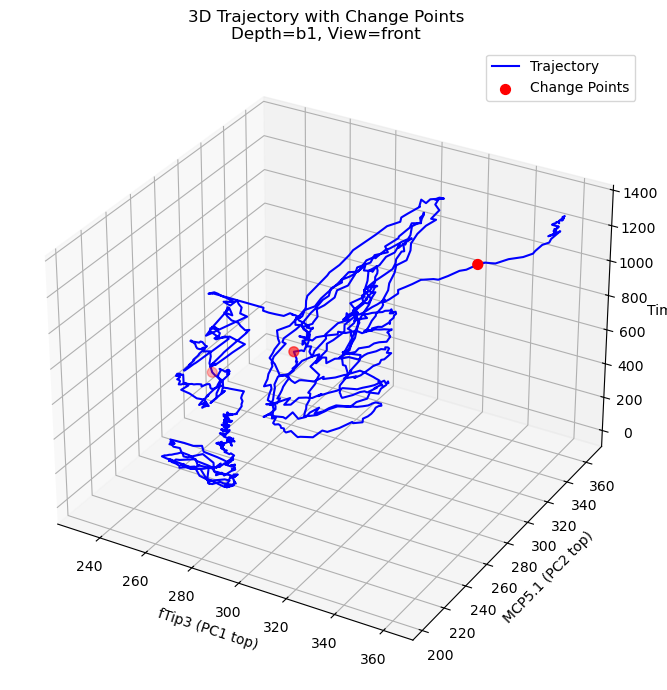

Change points (frame indices) for b1 front: [475, 715, 1265, 1331]

Processing depth=b1, view=side
MCP2.1


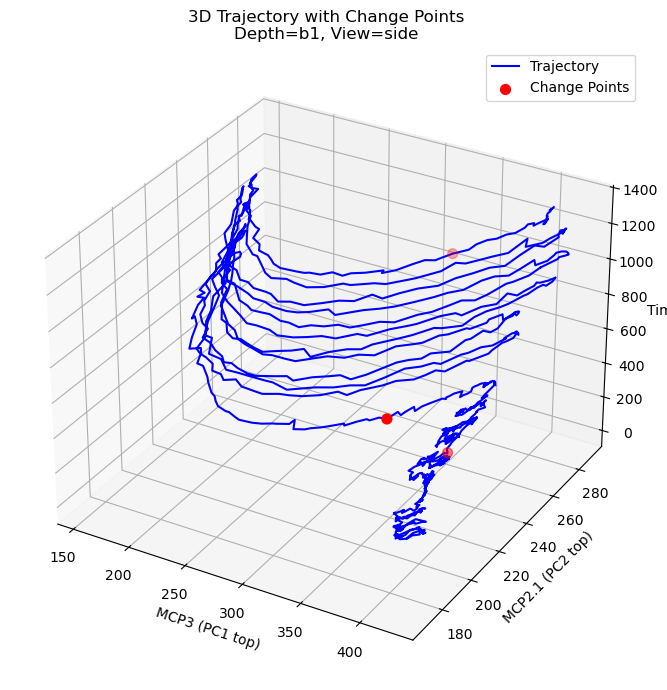

Change points (frame indices) for b1 side: [480, 720, 1265, 1317]

Processing depth=b2, view=front
MidForeArm


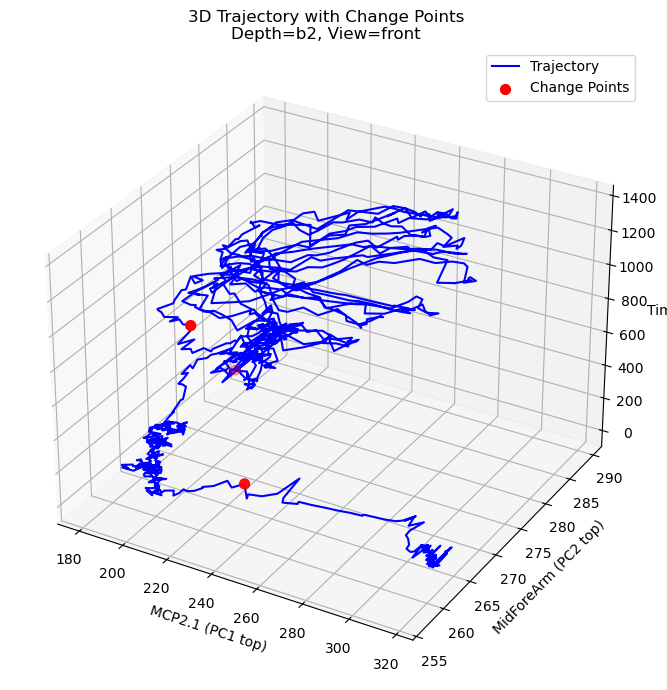

Change points (frame indices) for b2 front: [140, 560, 845, 1361]

Processing depth=b2, view=side
MCP2.1


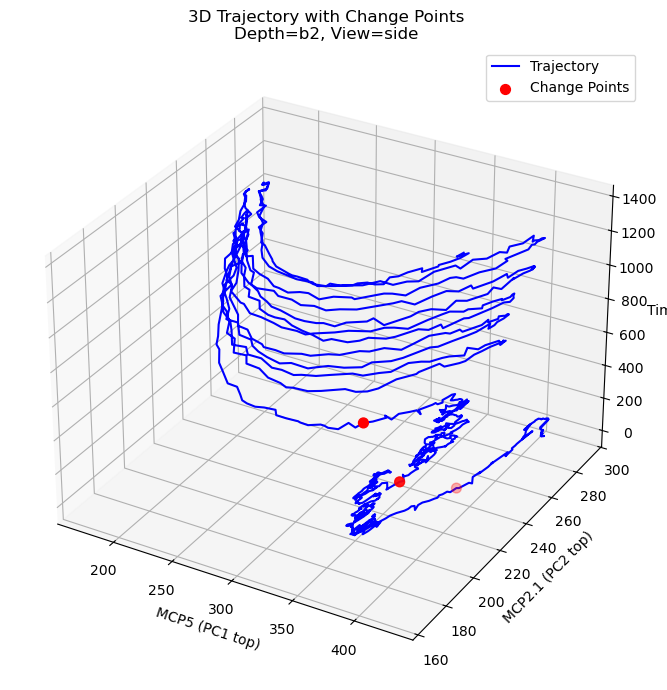

Change points (frame indices) for b2 side: [130, 540, 845, 1364]

Processing depth=b3, view=front
fTip5.1


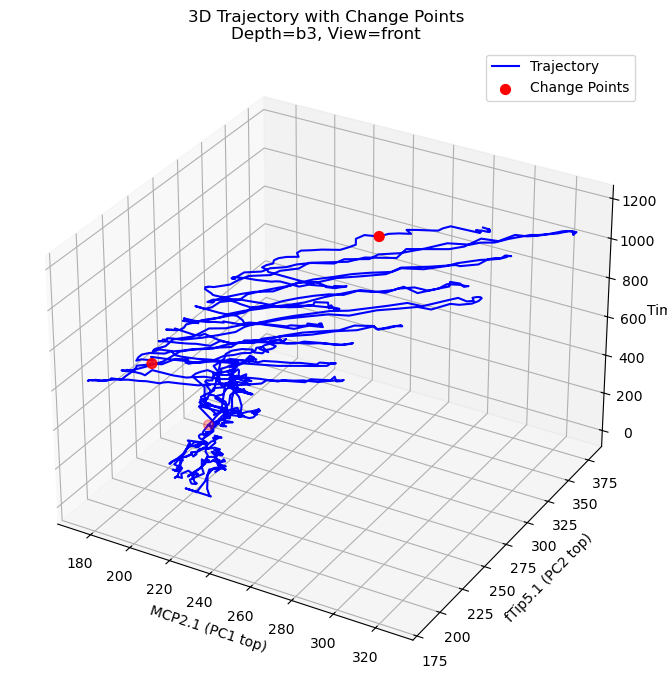

Change points (frame indices) for b3 front: [230, 615, 1135, 1181]

Processing depth=b3, view=side
MCP3.1


In [ ]:
import ruptures as rpt

# Parameters for ruptures
model = "rbf"
penalty_value = 30  # Adjust as needed

# Loop through unique depths and views from pca1_df or explained_df
depths = explained_df['depth'].unique()
views = explained_df['view'].unique()

for depth in depths:
    for view in views:
        print(f"\nProcessing depth={depth}, view={view}")

        # Get top PC1 and PC2 features
        top_feature_pc1 = get_top_feature(top5_pc1_df, depth, view, 'PC1')
        top_feature_pc2 = get_top_feature(top5_pc2_df, depth, view, 'PC2')

        print(top_feature_pc2)

        if top_feature_pc1 is None or top_feature_pc2 is None:
            print(f"Skipping {depth} {view} - missing top features")
            continue

        df_key = depth + ('f' if view == 'front' else 's')
        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        df = dataframes[df_key]

        if top_feature_pc1 not in df.columns or top_feature_pc2 not in df.columns:
            print(f"Features {top_feature_pc1} or {top_feature_pc2} not found in dataframe for {df_key}")
            continue

        # Extract data
        x = df[top_feature_pc1].to_numpy()
        y = df[top_feature_pc2].to_numpy()
        t = np.arange(len(x))

        # Stack for ruptures input
        signal = np.column_stack((x, y))  # shape (n_samples, 2)

        # Run RBF change point detection
        algo = rpt.Pelt(model=model).fit(signal)
        change_points = algo.predict(pen=penalty_value)


        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # 3D Line Plot of the Trajectory
        ax.plot(x, y, t, label='Trajectory', color='blue')

        # Plot change points as red scatter points
        cp_x = [x[i] for i in change_points[:-1]]  # exclude last if it's just the end
        cp_y = [y[i] for i in change_points[:-1]]
        cp_t = [t[i] for i in change_points[:-1]]
        ax.scatter(cp_x, cp_y, cp_t, color='red', s=50, label='Change Points')

        # Labels and title
        ax.set_xlabel(f"{top_feature_pc1} (PC1 top)")
        ax.set_ylabel(f"{top_feature_pc2} (PC2 top)")
        ax.set_zlabel("Time")
        ax.set_title(f"3D Trajectory with Change Points\nDepth={depth}, View={view}")
        ax.legend()

        plt.tight_layout()
        plt.show()




        # Print results
        print(f"Change points (frame indices) for {depth} {view}: {change_points}")


## Shows change points on 2D graph --> creates new df for indices


Processing depth=b1, view=front


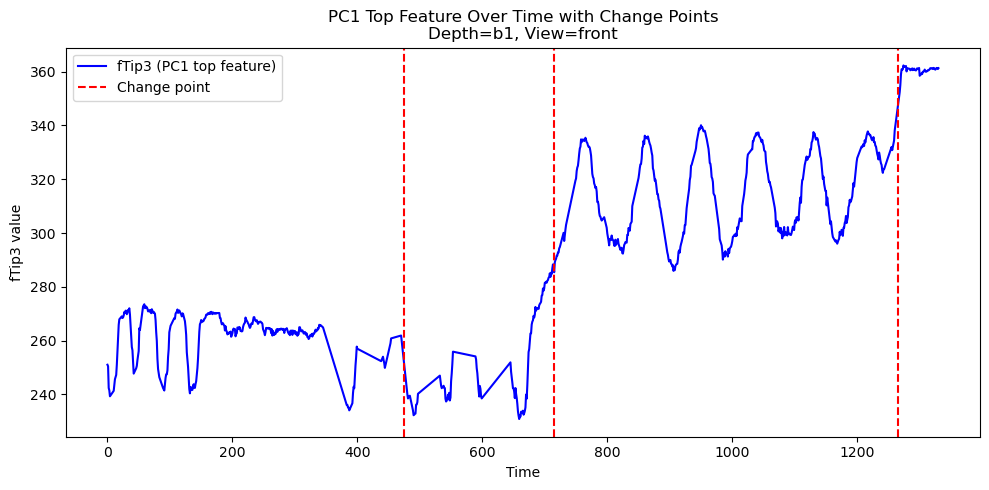

Change points (frame indices) for b1 front: [475, 715, 1265, 1331]

Processing depth=b1, view=side


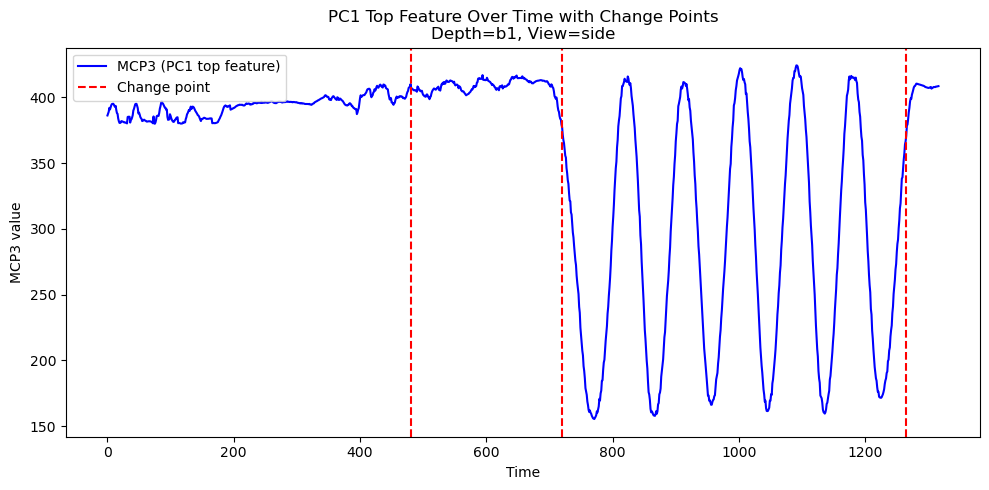

Change points (frame indices) for b1 side: [480, 720, 1265, 1317]

Processing depth=b2, view=front


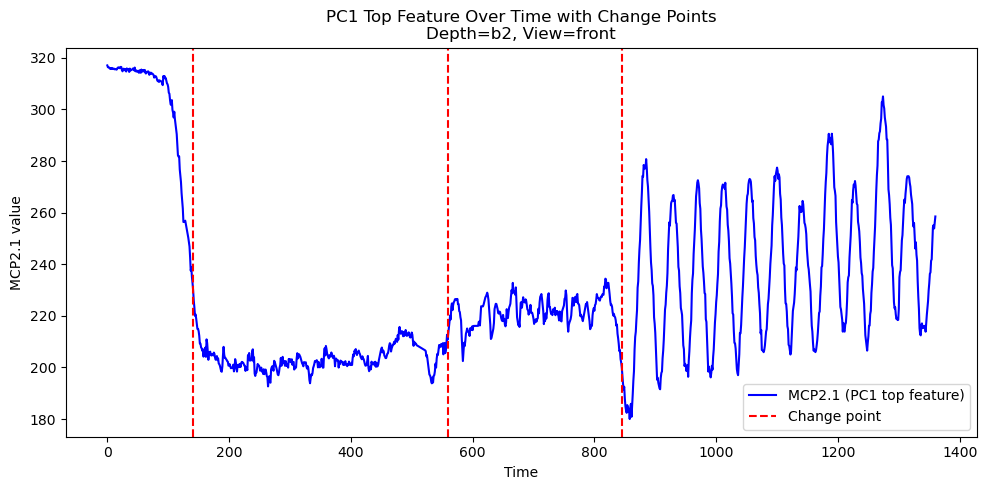

Change points (frame indices) for b2 front: [140, 560, 845, 1361]

Processing depth=b2, view=side


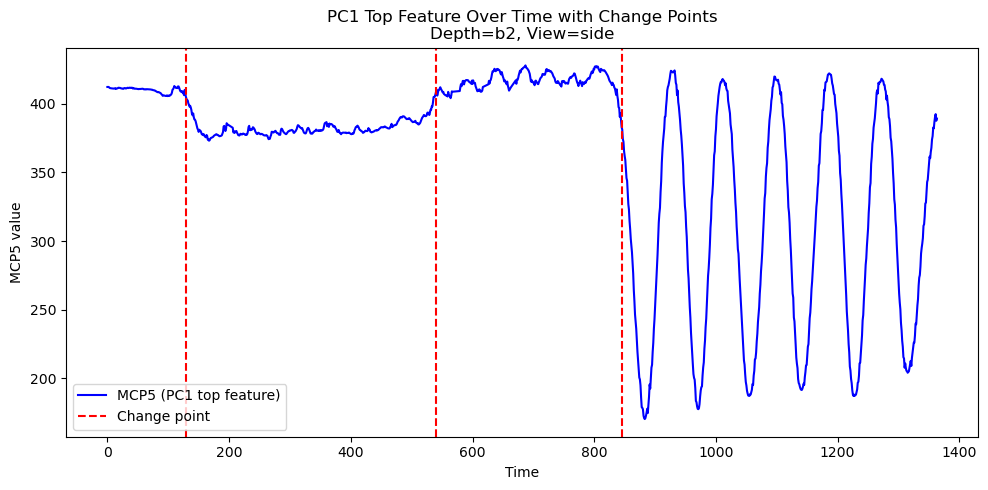

Change points (frame indices) for b2 side: [130, 540, 845, 1364]

Processing depth=b3, view=front


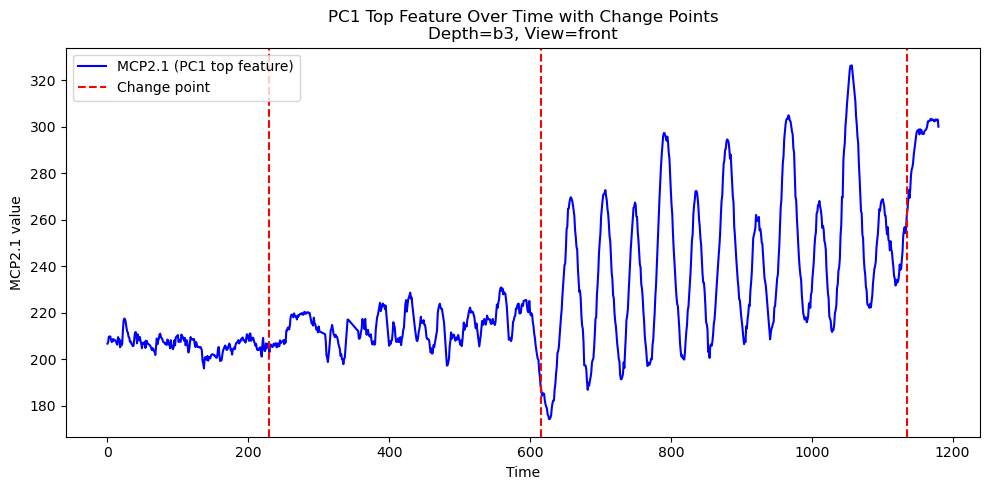

Change points (frame indices) for b3 front: [230, 615, 1135, 1181]

Processing depth=b3, view=side


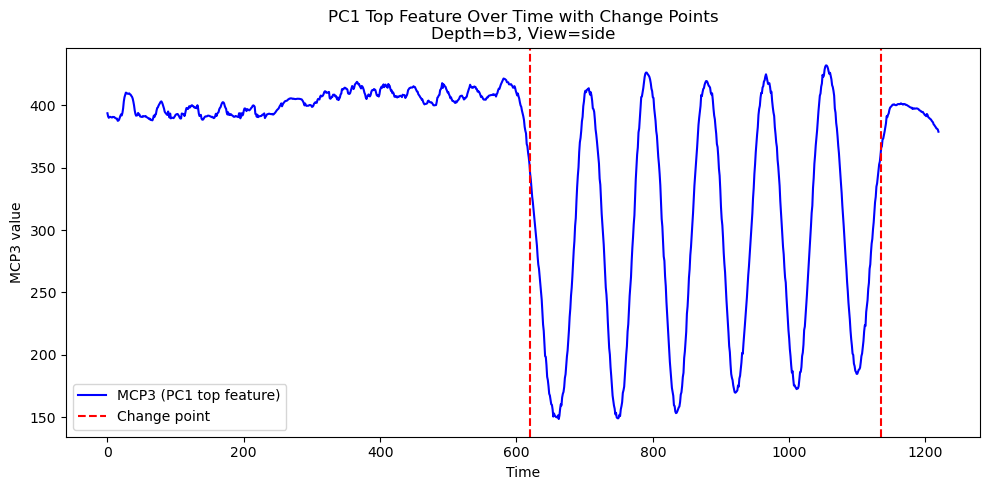

Change points (frame indices) for b3 side: [620, 1135, 1220]

Processing depth=c1, view=front


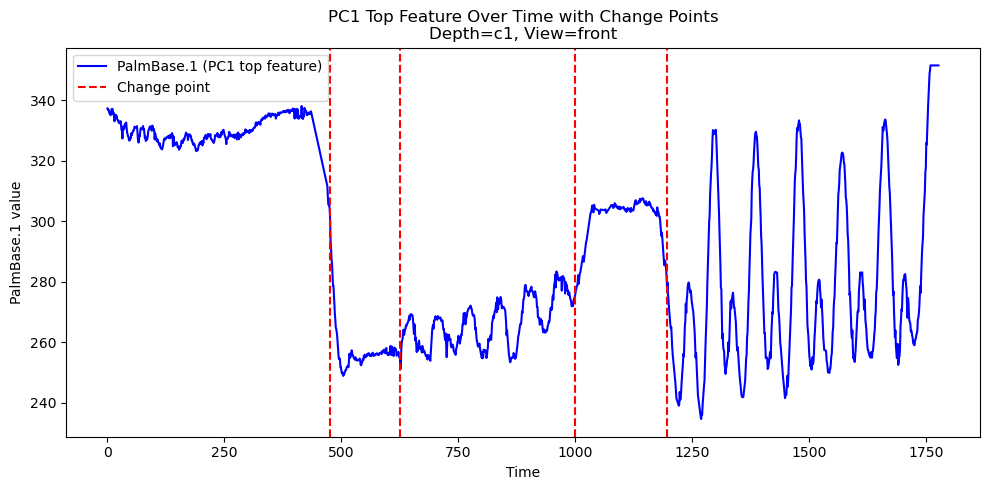

Change points (frame indices) for c1 front: [475, 625, 1000, 1195, 1777]

Processing depth=c1, view=side


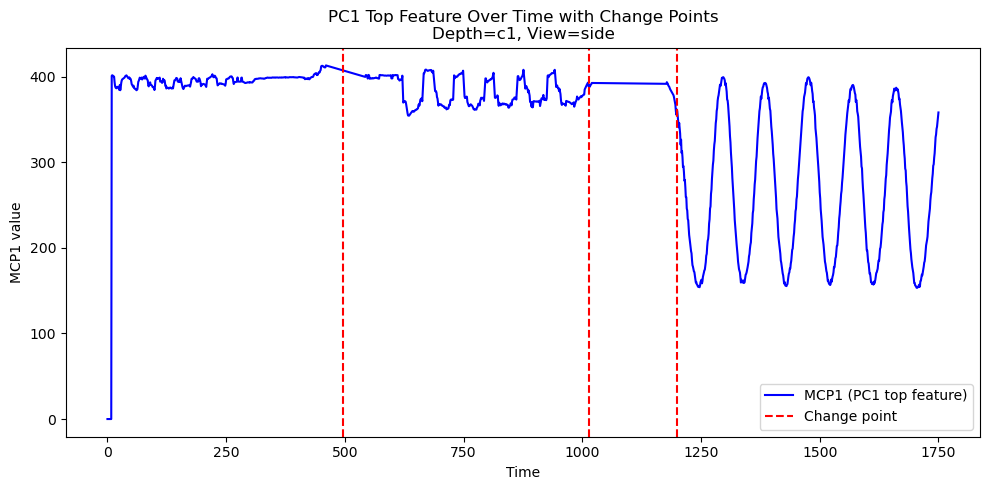

Change points (frame indices) for c1 side: [495, 1015, 1200, 1751]

Processing depth=c2, view=front


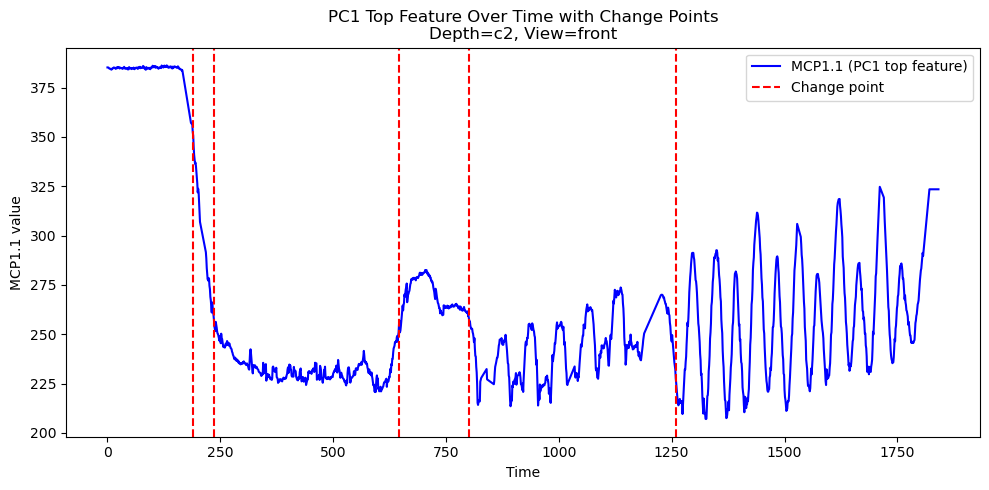

Change points (frame indices) for c2 front: [190, 235, 645, 800, 1260, 1842]

Processing depth=c2, view=side


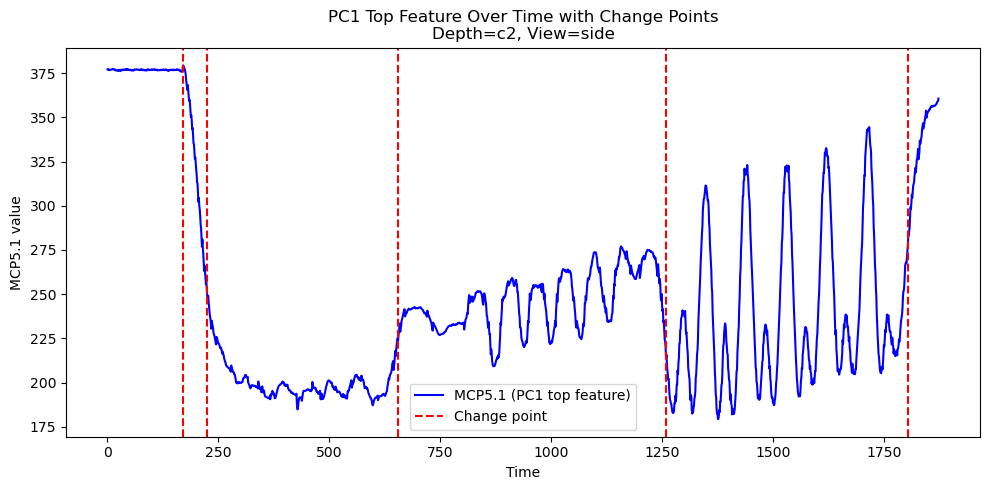

Change points (frame indices) for c2 side: [170, 225, 655, 1260, 1805, 1874]

Processing depth=c3, view=front


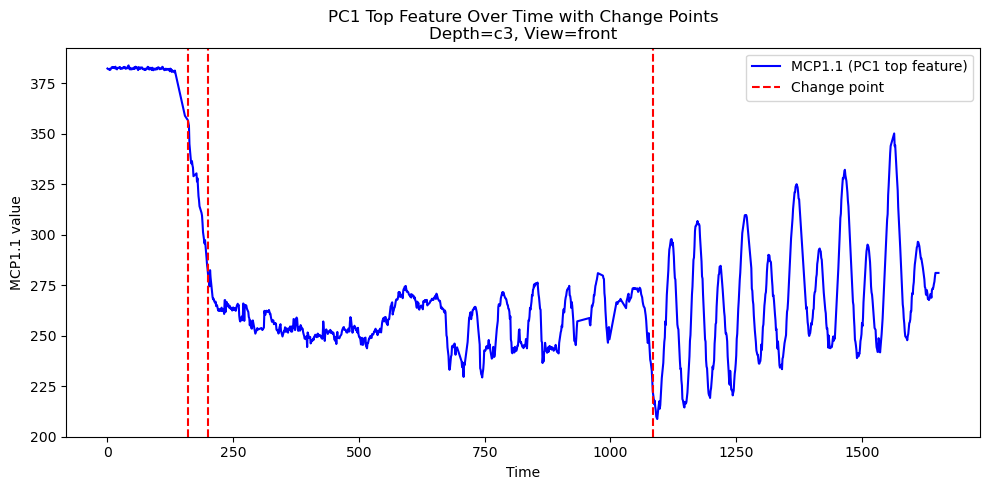

Change points (frame indices) for c3 front: [160, 200, 1085, 1653]

Processing depth=c3, view=side


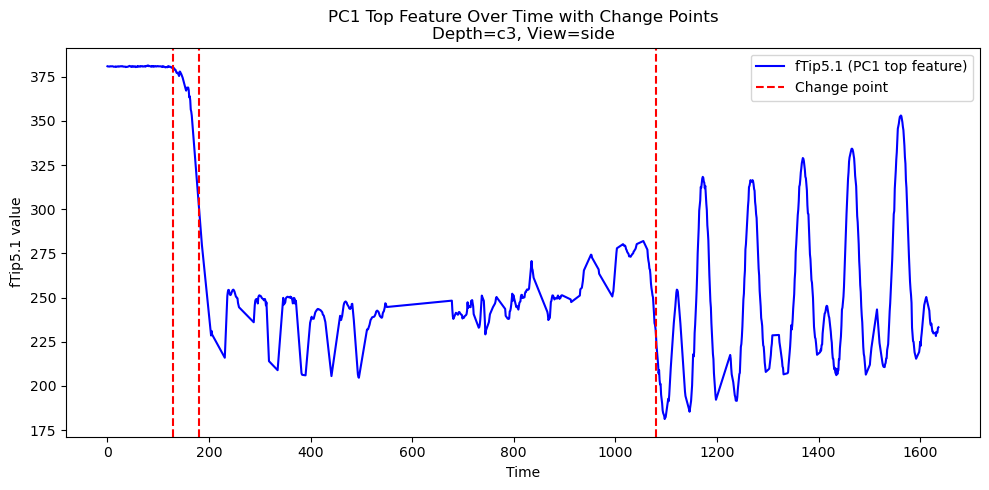

Change points (frame indices) for c3 side: [130, 180, 1080, 1637]

Processing depth=t1, view=front


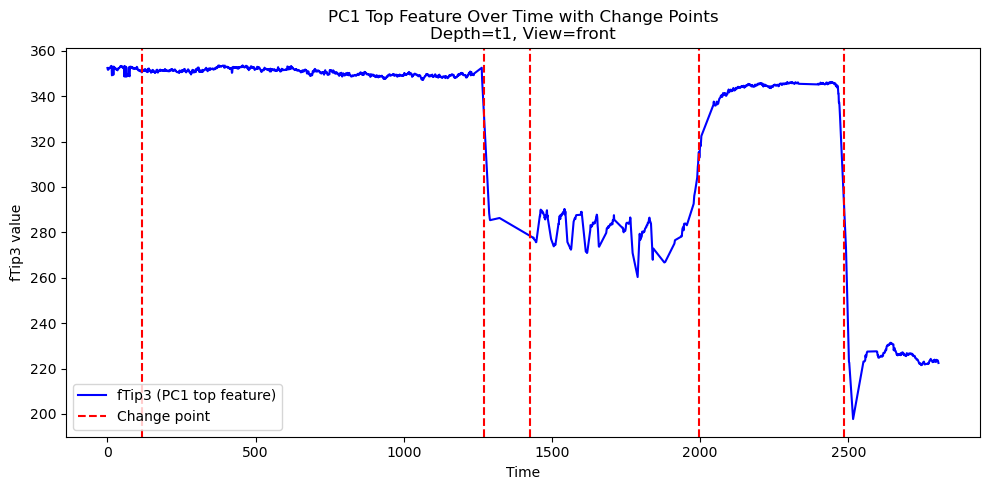

Change points (frame indices) for t1 front: [115, 1270, 1425, 1995, 2485, 2805]

Processing depth=t1, view=side


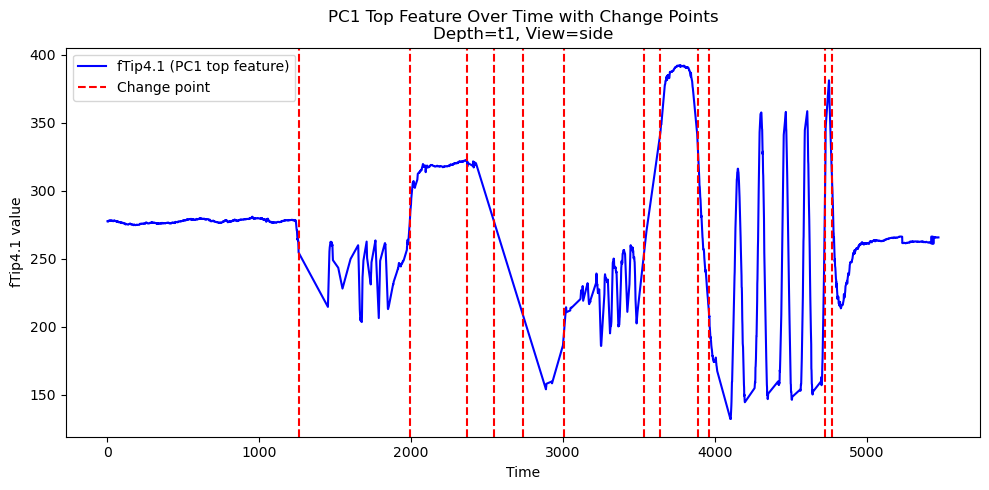

Change points (frame indices) for t1 side: [1260, 1990, 2365, 2545, 2735, 3010, 3535, 3640, 3890, 3960, 4725, 4775, 5474]

Processing depth=t2, view=front


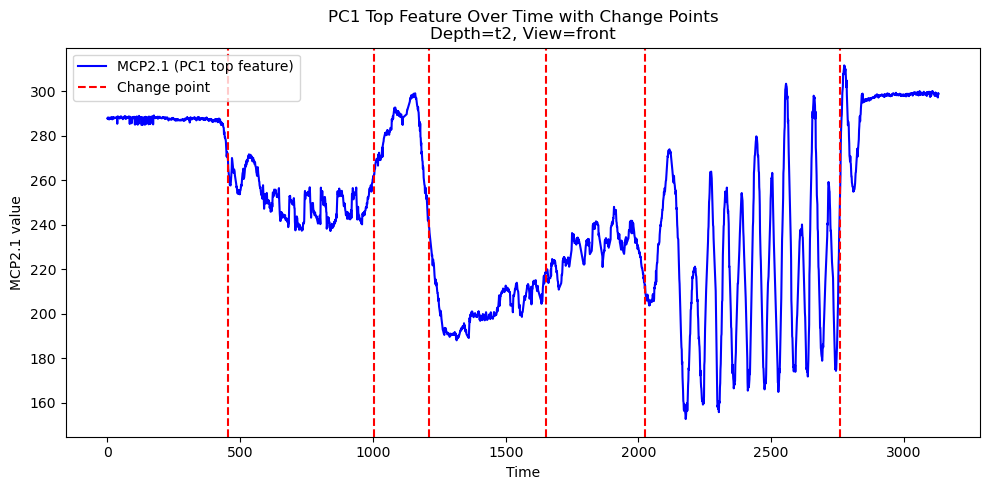

Change points (frame indices) for t2 front: [455, 1005, 1210, 1650, 2025, 2760, 3131]

Processing depth=t2, view=side


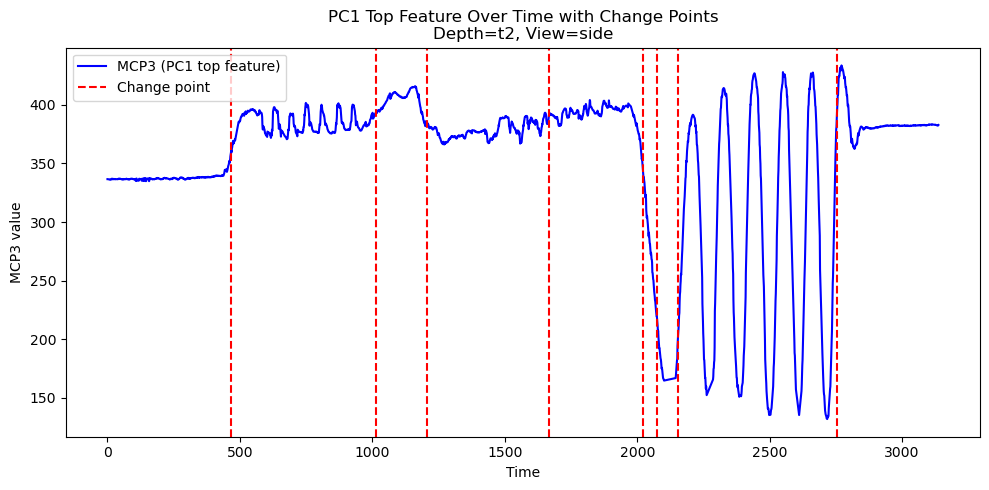

Change points (frame indices) for t2 side: [465, 1015, 1205, 1665, 2020, 2075, 2155, 2755, 3138]

Processing depth=t3, view=front


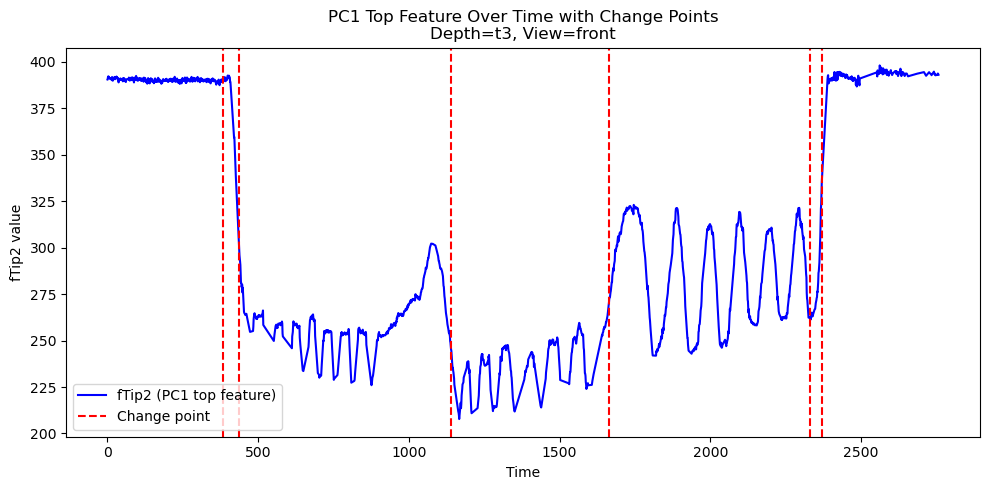

Change points (frame indices) for t3 front: [385, 435, 1140, 1665, 2330, 2370, 2758]

Processing depth=t3, view=side


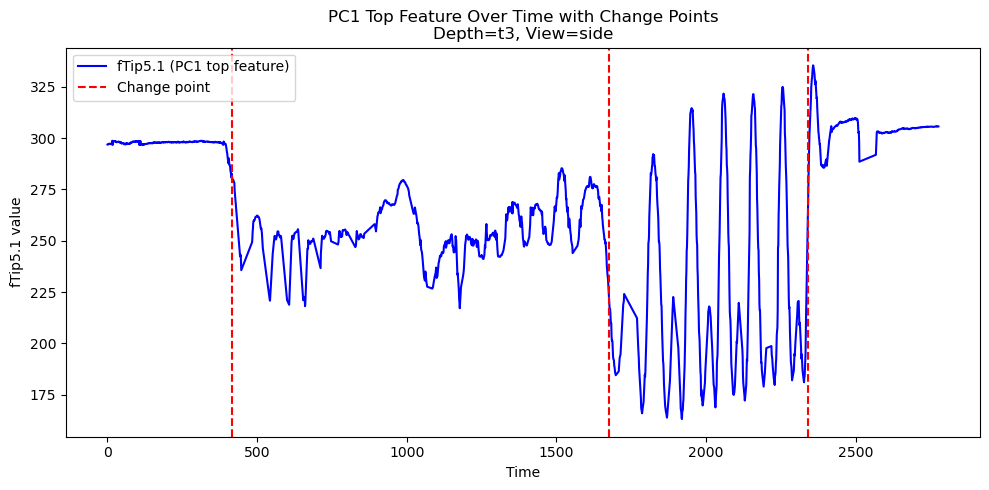

Change points (frame indices) for t3 side: [415, 1675, 2340, 2777]


In [296]:
results_list = []

# Parameters for ruptures
model = "rbf"
penalty_value = 30  # Adjust as needed

for depth in depths:
    for view in views:
        print(f"\nProcessing depth={depth}, view={view}")

        # Get top PC1 and PC2 features
        top_feature_pc1 = get_top_feature(top5_pc1_df, depth, view, 'PC1')
        top_feature_pc2 = get_top_feature(top5_pc2_df, depth, view, 'PC2')

        if top_feature_pc1 is None or top_feature_pc2 is None:
            print(f"Skipping {depth} {view} - missing top features")
            continue

        df_key = depth + ('f' if view == 'front' else 's')
        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        df = dataframes[df_key]

        if top_feature_pc1 not in df.columns or top_feature_pc2 not in df.columns:
            print(f"Features {top_feature_pc1} or {top_feature_pc2} not found in dataframe for {df_key}")
            continue

        # Extract data
        x = df[top_feature_pc1].to_numpy()
        y = df[top_feature_pc2].to_numpy()
        t = np.arange(len(x))

        # Stack for ruptures input
        signal = np.column_stack((x, y))  # shape (n_samples, 2)

        # Run RBF change point detection
        algo = rpt.Pelt(model=model).fit(signal)
        change_points = algo.predict(pen=penalty_value)



        # Inside the nested loop after change_points are computed
        plt.figure(figsize=(10, 5))
        plt.plot(t, x, label=f"{top_feature_pc1} (PC1 top feature)", color='blue')
        for cp in change_points[:-1]:  # Skip the last point if it's just the end of signal
            plt.axvline(x=cp, color='red', linestyle='--', label='Change point' if cp == change_points[0] else "")
        plt.xlabel("Time")
        plt.ylabel(f"{top_feature_pc1} value")
        plt.title(f"PC1 Top Feature Over Time with Change Points\nDepth={depth}, View={view}")
        plt.legend()
        plt.tight_layout()
        plt.show()




        # Print results
        print(f"Change points (frame indices) for {depth} {view}: {change_points}")

        # Create a dictionary for storing change point results
        dic_indices = {
            "depth": depth,
            "view": view,
            "component": "indices"
        }

        # Save the top features and their change points
        dic_indices["feature_1"] = top_feature_pc1
        dic_indices["feature_2"] = top_feature_pc2
        dic_indices["change_points"] = change_points

        # Assuming you're collecting multiple such dictionaries into a list
        results_list.append(dic_indices)





## Visualize indices df

In [297]:
df_indices = pd.DataFrame(results_list)

df_indices 

depth   view component   feature_1   feature_2  \
0     b1  front   indices       fTip3      MCP5.1   
1     b1   side   indices        MCP3      MCP2.1   
2     b2  front   indices      MCP2.1  MidForeArm   
3     b2   side   indices        MCP5      MCP2.1   
4     b3  front   indices      MCP2.1     fTip5.1   
5     b3   side   indices        MCP3      MCP3.1   
6     c1  front   indices  PalmBase.1       fTip2   
7     c1   side   indices        MCP1      MCP2.1   
8     c2  front   indices      MCP1.1    PalmBase   
9     c2   side   indices      MCP5.1       fTip1   
10    c3  front   indices      MCP1.1    PalmBase   
11    c3   side   indices     fTip5.1       fTip1   
12    t1  front   indices       fTip3     fTip5.1   
13    t1   side   indices     fTip4.1     Elbow.1   
14    t2  front   indices      MCP2.1  PalmBase.1   
15    t2   side   indices        MCP3      MCP2.1   
16    t3  front   indices       fTip2     fTip5.1   
17    t3   side   indices     fTip5.1       fTip3   

                                        change_points  
0                              [475, 715, 1265, 1331]  
1                              [480, 720, 1265, 1317]  
2                               [140, 560, 845, 1361]  
3                               [130, 540, 845, 1364]  
4                              [230, 615, 1135, 1181]  
5                                   [620, 1135, 1220]  
6                        [475, 625, 1000, 1195, 1777]  
7                             [495, 1015, 1200, 1751]  
8                    [190, 235, 645, 800, 1260, 1842]  
9                   [170, 225, 655, 1260, 1805, 1874]  
10                             [160, 200, 1085, 1653]  
11                             [130, 180, 1080, 1637]  
12                [115, 1270, 1425, 1995, 2485, 2805]  
13  [1260, 1990, 2365, 2545, 2735, 3010, 3535, 364...  
14          [455, 1005, 1210, 1650, 2025, 2760, 3131]  
15  [465, 1015, 1205, 1665, 2020, 2075, 2155, 2755...  
16           [385, 435, 1140, 1665, 2330, 2370, 2758]  
17                            [415, 1675, 2340, 2777]

## Averaging close datapoints

In [298]:
# Create an empty list to hold averaged points for each row
averaged_points_list = []

# Loop through each row in the DataFrame
for _, row in df_indices.iterrows():
    change_points = row['change_points']
    averaged_points = average_close_indices(change_points, threshold=100)
    averaged_points_list.append(averaged_points)

# Assign the results as a new column in the DataFrame
df_indices['averaged_points'] = averaged_points_list

## Creating movement df for armEF

In [299]:
df_movements = pd.DataFrame(columns=['dataset', 'view', 'movement', 'indices'])

for _, row in df_indices.iterrows():
    all_indices = row['averaged_points']
    movement = 'arm_EF'

    if len(all_indices) == 1:
        continue

    dif = all_indices[-2] - all_indices[-1]
    print(f'the difference is {dif}')

    if np.abs(all_indices[-2] - all_indices[-1]) < 500:
        if len(all_indices) >= 3:
            start = all_indices[-3]
            end = all_indices[-2]
        else: 
            start = all_indices[-2]
            end = all_indices[-1]
    else:
        start = all_indices[-2]
        end = all_indices[-1]
        

    df_movements = pd.concat([
    df_movements,
    pd.DataFrame([{
        'dataset': row['depth'],        # <- use `row` to access data from df_indices
        'view': row['view'],
        'movement': movement,
        'indices': (start, end)
    }])
], ignore_index=True)

print(df_movements)

the difference is -583
the difference is -571
the difference is -516
the difference is -519
the difference is -543
the difference is -557
the difference is -582
the difference is -551
the difference is -582
the difference is -579
the difference is -568
the difference is -557
the difference is -320
the difference is -724
the difference is -371
the difference is -383
the difference is -408
the difference is -437
   dataset   view movement       indices
0       b1  front   arm_EF   (715, 1298)
1       b1   side   arm_EF   (720, 1291)
2       b2  front   arm_EF   (845, 1361)
3       b2   side   arm_EF   (845, 1364)
4       b3  front   arm_EF   (615, 1158)
5       b3   side   arm_EF   (620, 1177)
6       c1  front   arm_EF  (1195, 1777)
7       c1   side   arm_EF  (1200, 1751)
8       c2  front   arm_EF  (1260, 1842)
9       c2   side   arm_EF  (1260, 1839)
10      c3  front   arm_EF  (1085, 1653)
11      c3   side   arm_EF  (1080, 1637)
12      t1  front   arm_EF  (1995, 2485)
13      t1  

## Visualizing armEF segmentation

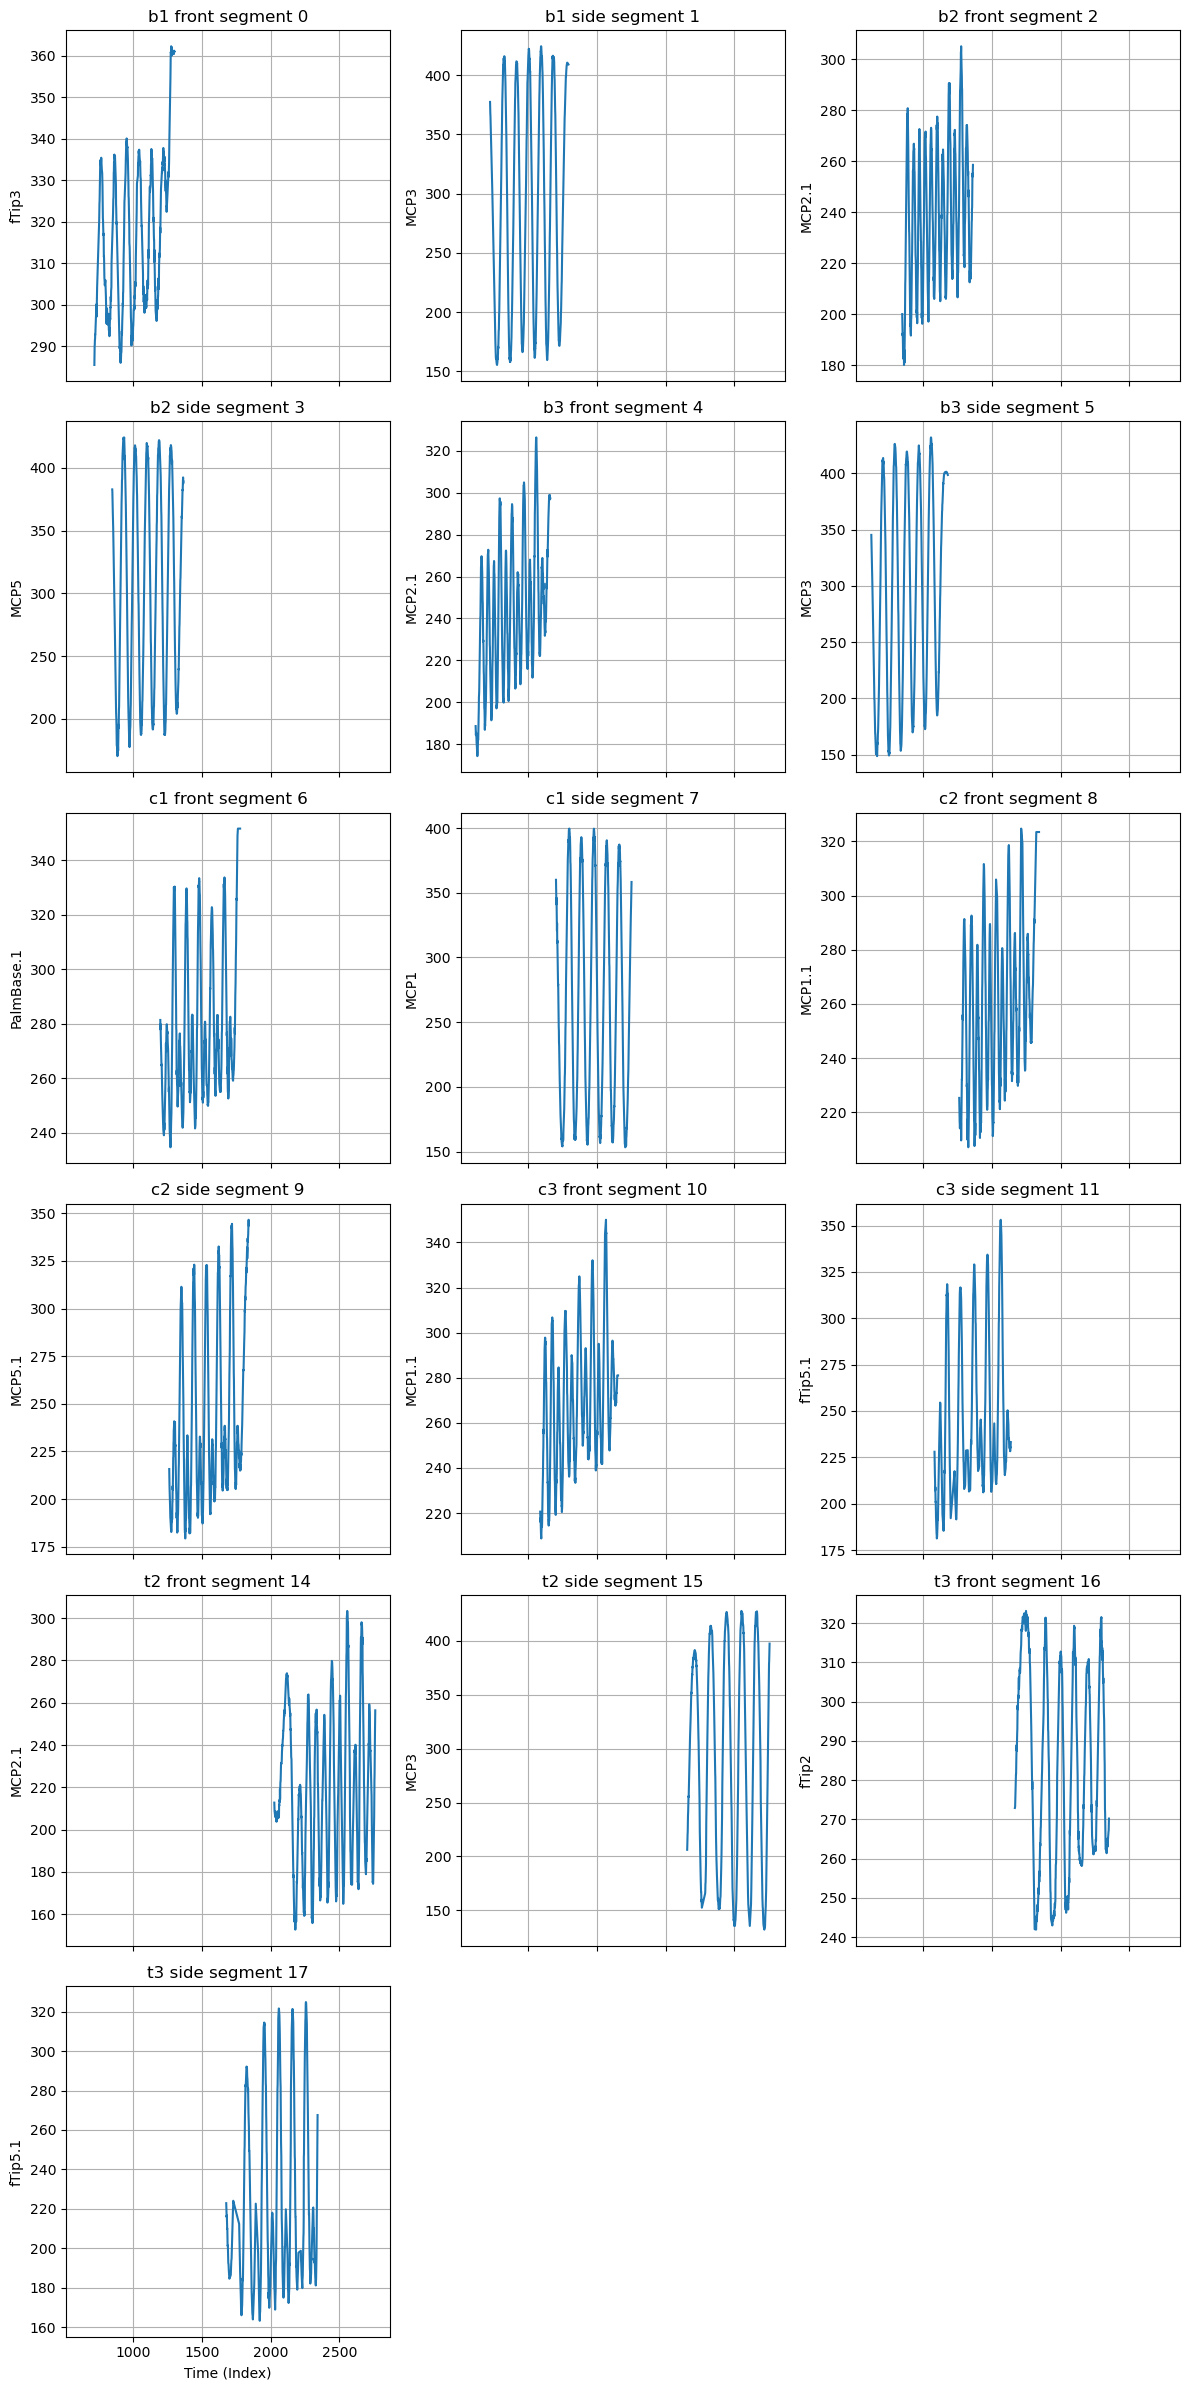

In [300]:
import matplotlib.pyplot as plt
import math

# Filter out rows where depth is 't1'
filtered_movements = df_movements[df_movements['dataset'] != 't1']
n = len(filtered_movements)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * rows), sharex=True)
axs = axs.flatten()

for idx, (i, row) in enumerate(filtered_movements.iterrows()):
    depth = row['dataset']
    view_type = row['view']
    start, end = row['indices']

    df_key = depth + ('f' if view_type == 'front' else 's')
    if df_key not in dataframes:
        print(f"Data for {df_key} not found.")
        continue

    df = dataframes[df_key]

    top_feature = get_top_feature(top5_pc1_df, depth, view_type, 'PC1')
    if top_feature not in df.columns:
        print(f"{top_feature} not found in data for {df_key}")
        continue

    segment = df[top_feature].iloc[start:end+1]

    ax = axs[idx]
    ax.plot(segment.index, segment.values)
    ax.set_title(f"{depth} {view_type} segment {i}")
    ax.set_ylabel(f"{top_feature}")
    ax.grid(True)

# Hide any unused subplots
for i in range(n, len(axs)):
    fig.delaxes(axs[i])

plt.xlabel("Time (Index)")
plt.tight_layout()
plt.show()


## Run PCA on only handOC and handPS time - working on now

In [312]:
# New containers for start-segment PCA data
pca1_start_rows = []
pca2_start_rows = []
explained_start_rows = []
top5_start_pc1_rows = []
top5_start_pc2_rows = []

view_map = {"front": "f", "side": "s"}

for _, row in df_movements.iterrows():
    depth = row["dataset"]
    view = row["view"]

    # Skip if missing
    if pd.isna(depth) or pd.isna(view):
        continue

    # Map "front"/"side" to "f"/"s"
    view_letter = view_map.get(view.lower())

    if view_letter is None:
        print(f"Unrecognized view: {view}")
        continue

    base = f"{depth}{view_letter}"

    if base not in dataframes:
        print(f"Skipping {base} - not found in dataframes.")
        continue

    df_full = dataframes[base]
    
    # Trim initial zeros like before
    df_trimmed = trim_initial_zeros(df_full)

    # Get starting segment: from 0 to first change point
    change_points = row['indices']  
    if not change_points or len(change_points) == 0:
        continue  # Skip if no change points
    
    first_cp = int(change_points[0])
    df_segment = df_trimmed.iloc[:first_cp]

    # Run PCA on start segment
    X_pca, explained_ratio, explained_raw, components = run_PCA(df_segment, None, base, "start")

    used_columns = df_segment.loc[:, ~df_segment.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()

    pc1 = components[0]
    pc2 = components[1]

    # Build PCA1 row
    row_pc1 = {"depth": depth, "view": view_letter, "component": "PC1"}
    row_pc2 = {"depth": depth, "view": view_letter, "component": "PC2"}
    
    for feat, w1, w2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = w1
        row_pc2[feat] = w2

    pca1_start_rows.append(row_pc1)
    pca2_start_rows.append(row_pc2)

    explained_start_rows.append({
        "depth": depth,
        "view": view_letter,
        "PC1_var": explained_ratio[0],
        "PC2_var": explained_ratio[1]
    })

    # Top 5 for PC1
    contributions = list(zip(final_cols, pc1))
    contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    top5 = contributions[:5]

    top5_dict = {
        "depth": depth,
        "view": view_letter
    }
    for idx, (feat, weight) in enumerate(top5):
        top5_dict[f"feature_{idx+1}"] = feat
        top5_dict[f"weight_{idx+1}"] = weight
    top5_start_pc1_rows.append(top5_dict)


    # Top 5 for PC2
    contributions_pc2 = list(zip(final_cols, pc2))
    contributions_pc2.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc2 = contributions_pc2[:5]

    top5_dict_pc2 = {
        "depth": depth,
        "view": view_letter
    }
    for idx, (feat, weight) in enumerate(top5_pc2):
        top5_dict_pc2[f"feature_{idx+1}"] = feat
        top5_dict_pc2[f"weight_{idx+1}"] = weight
    top5_start_pc2_rows.append(top5_dict_pc2)


# At the end: convert to dataframes
pca1_start_df = pd.DataFrame(pca1_start_rows)
pca2_start_df = pd.DataFrame(pca2_start_rows)
explained_start_df = pd.DataFrame(explained_start_rows)
top5_start_pc1_df = pd.DataFrame(top5_start_pc1_rows)
top5_start_pc2_df = pd.DataFrame(top5_start_pc2_rows)



In [313]:
results_list2 = []

# Parameters for ruptures
model = "rbf"
penalty_value = 30  # Adjust as needed

for depth in depths:
    for view in views:
        print(f"\nProcessing depth={depth}, view={view}")

        # Get top PC1 and PC2 features
        top_feature_pc1 = get_top_feature(top5_start_pc1_df, depth, view, 'PC1')
        top_feature_pc2 = get_top_feature(top5_start_pc2_df, depth, view, 'PC2')

        if top_feature_pc1 is None or top_feature_pc2 is None:
            print(f"Skipping {depth} {view} - missing top features")
            continue

        df_key = depth + ('f' if view == 'front' else 's')
        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        df = dataframes[df_key]

        if top_feature_pc1 not in df.columns or top_feature_pc2 not in df.columns:
            print(f"Features {top_feature_pc1} or {top_feature_pc2} not found in dataframe for {df_key}")
            continue

        # Extract data
        x = df[top_feature_pc1].to_numpy()
        y = df[top_feature_pc2].to_numpy()
        t = np.arange(len(x))

        # Stack for ruptures input
        signal = np.column_stack((x, y))  # shape (n_samples, 2)

        # Run RBF change point detection
        algo = rpt.Pelt(model=model).fit(signal)
        change_points = algo.predict(pen=penalty_value)



        # Inside the nested loop after change_points are computed
        plt.figure(figsize=(10, 5))
        plt.plot(t, x, label=f"{top_feature_pc1} (PC1 top feature)", color='blue')
        for cp in change_points[:-1]:  # Skip the last point if it's just the end of signal
            plt.axvline(x=cp, color='red', linestyle='--', label='Change point' if cp == change_points[0] else "")
        plt.xlabel("Time")
        plt.ylabel(f"{top_feature_pc1} value")
        plt.title(f"PC1 Top Feature Over Time with Change Points\nDepth={depth}, View={view}")
        plt.legend()
        plt.tight_layout()
        plt.show()




        # Print results
        print(f"Change points (frame indices) for {depth} {view}: {change_points}")

        # Create a dictionary for storing change point results
        dic_indices = {
            "depth": depth,
            "view": view,
            "component": "indices"
        }

        # Save the top features and their change points
        dic_indices["feature_1"] = top_feature_pc1
        dic_indices["feature_2"] = top_feature_pc2
        dic_indices["change_points"] = change_points

        # Assuming you're collecting multiple such dictionaries into a list
        results_list2.append(dic_indices)






Processing depth=b1, view=front


KeyError: 'component'

## NOT WORKING YET!!!!!

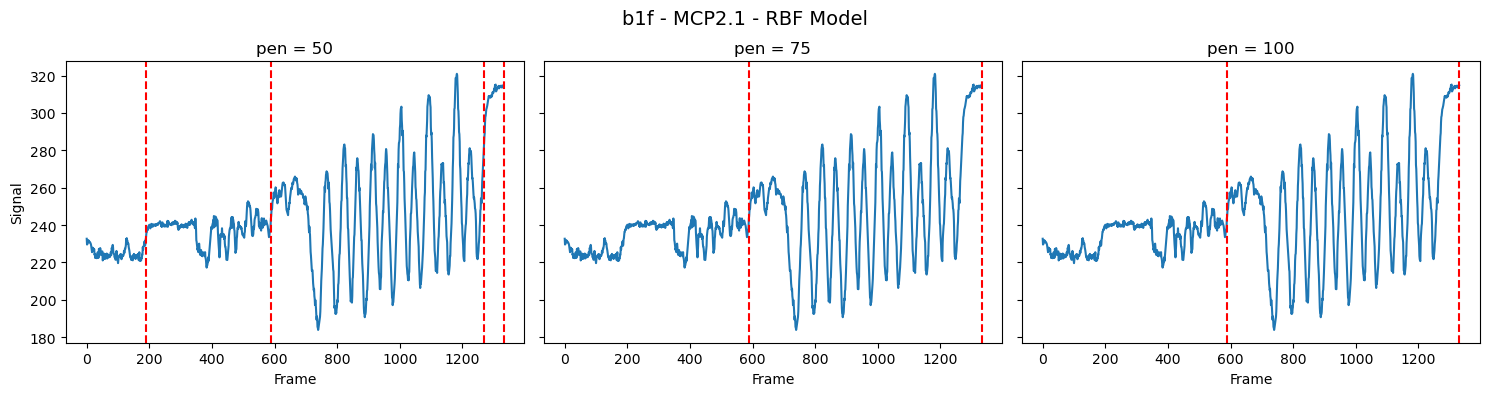

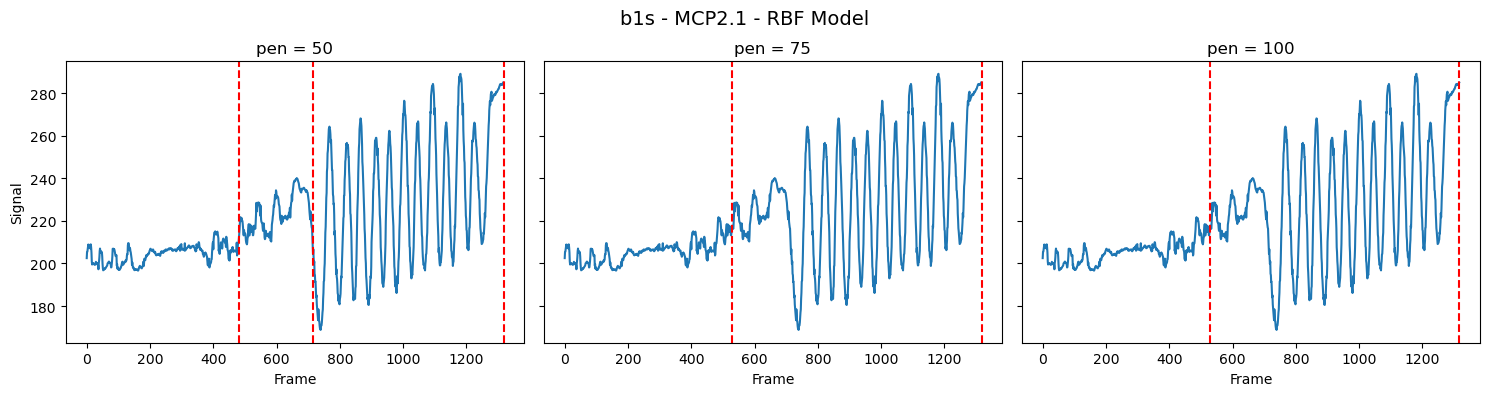

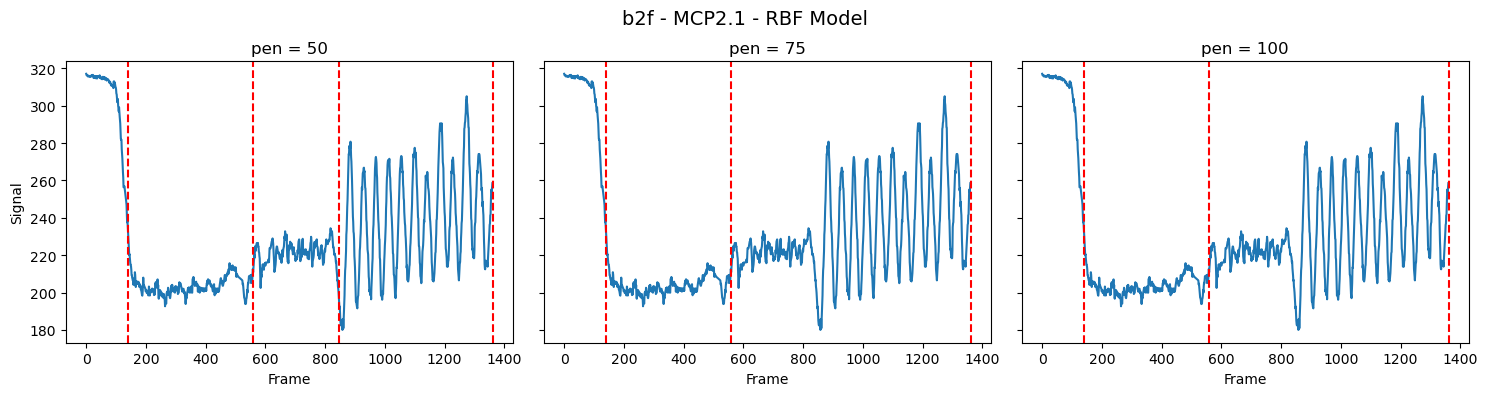

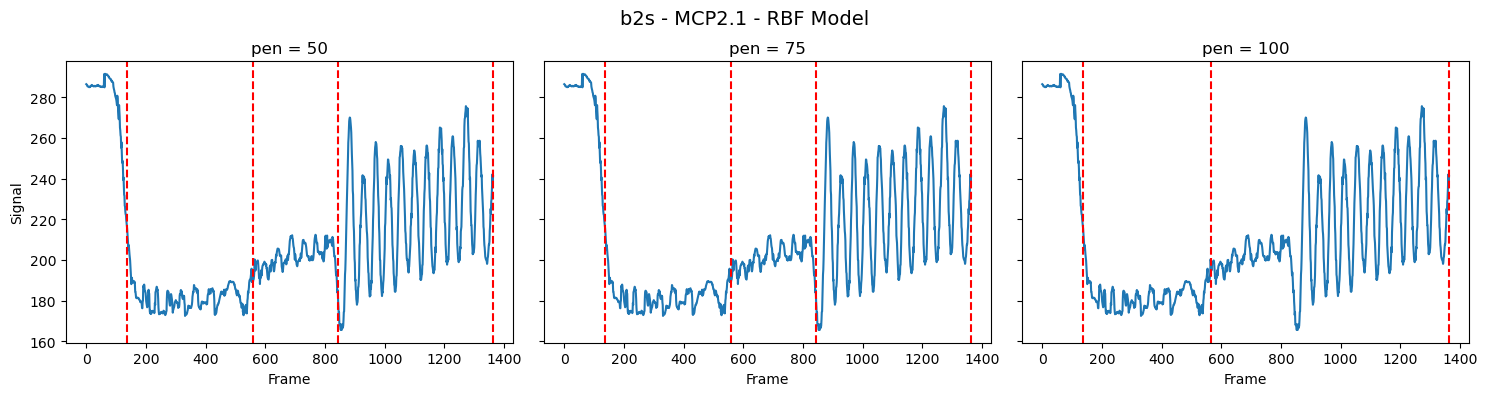

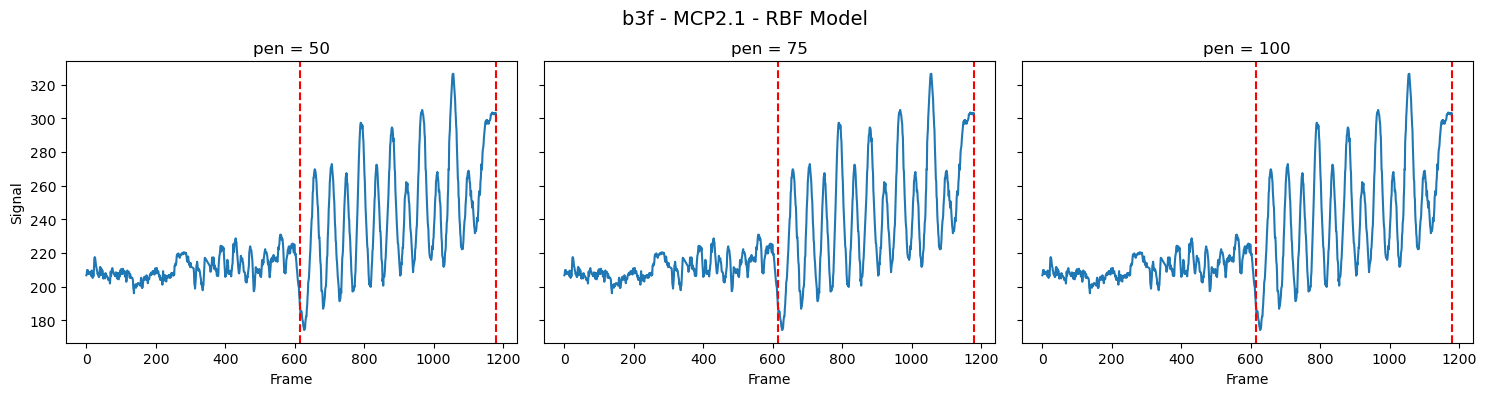

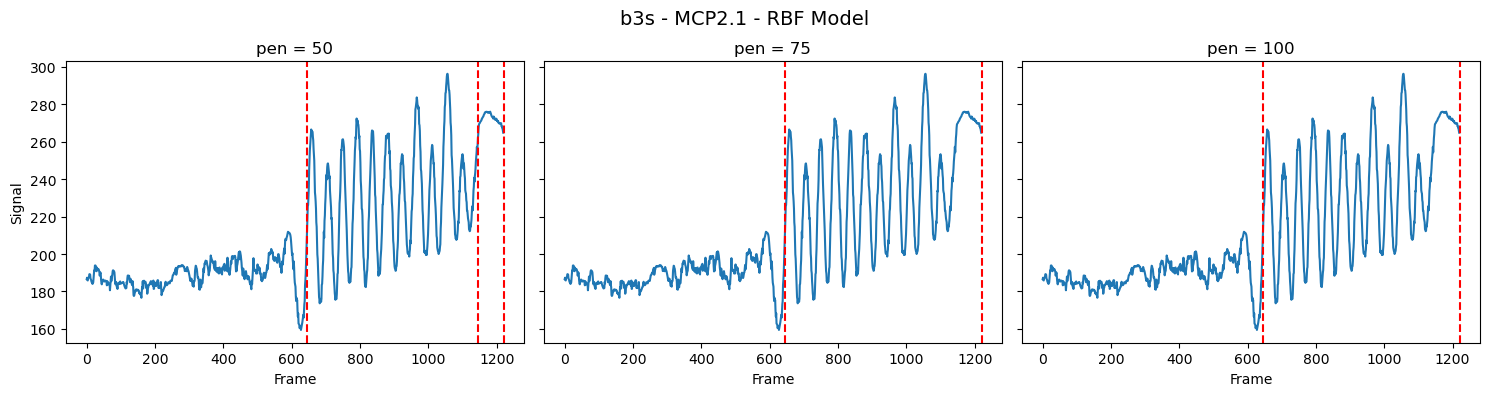

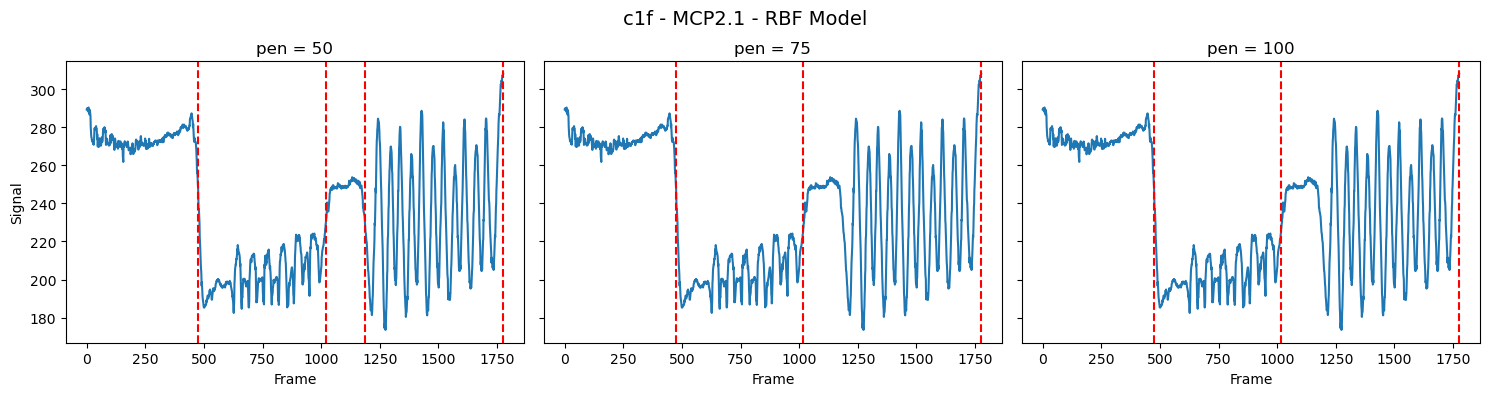

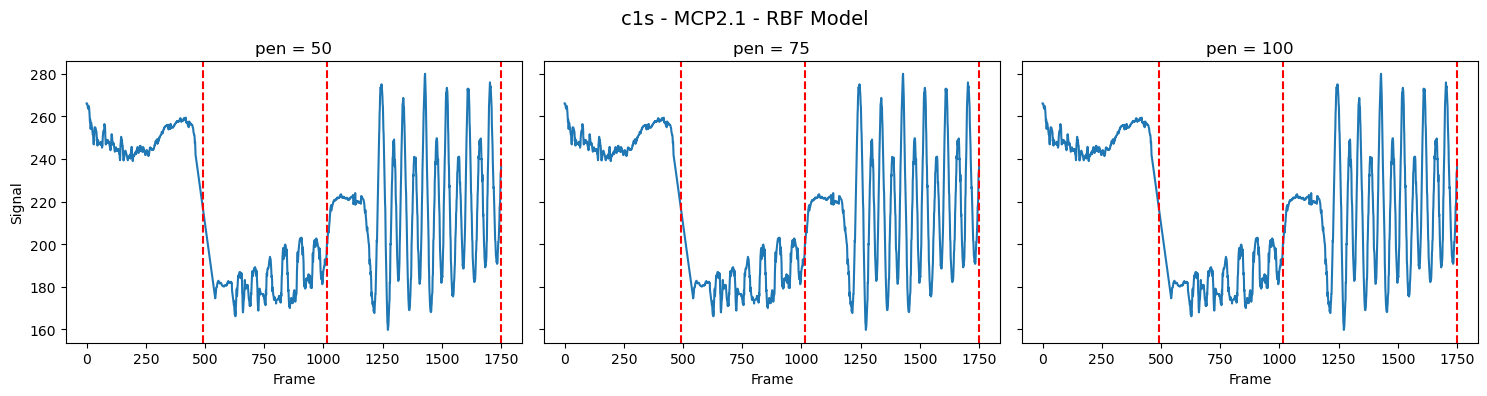

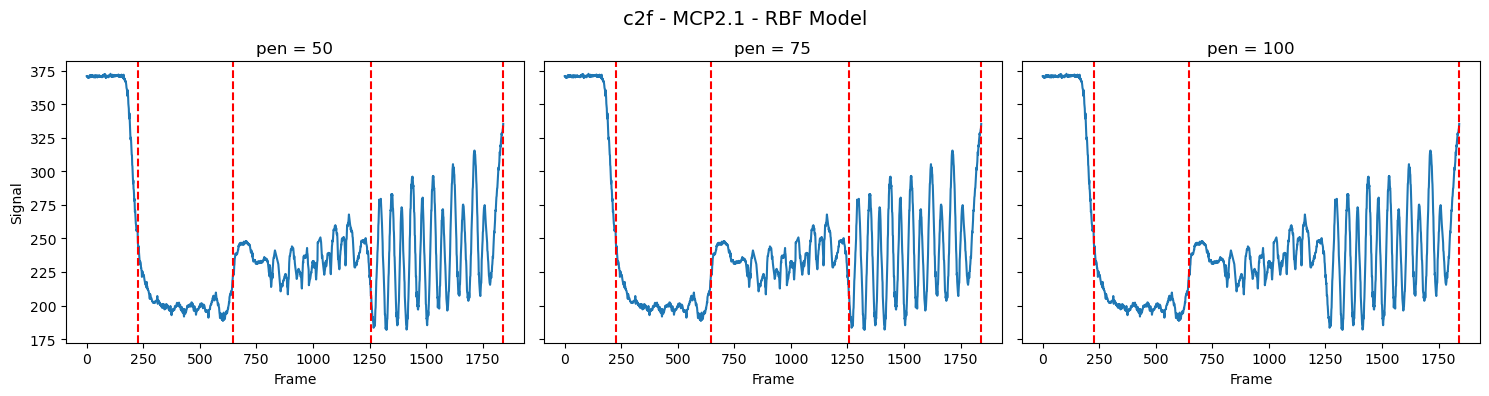

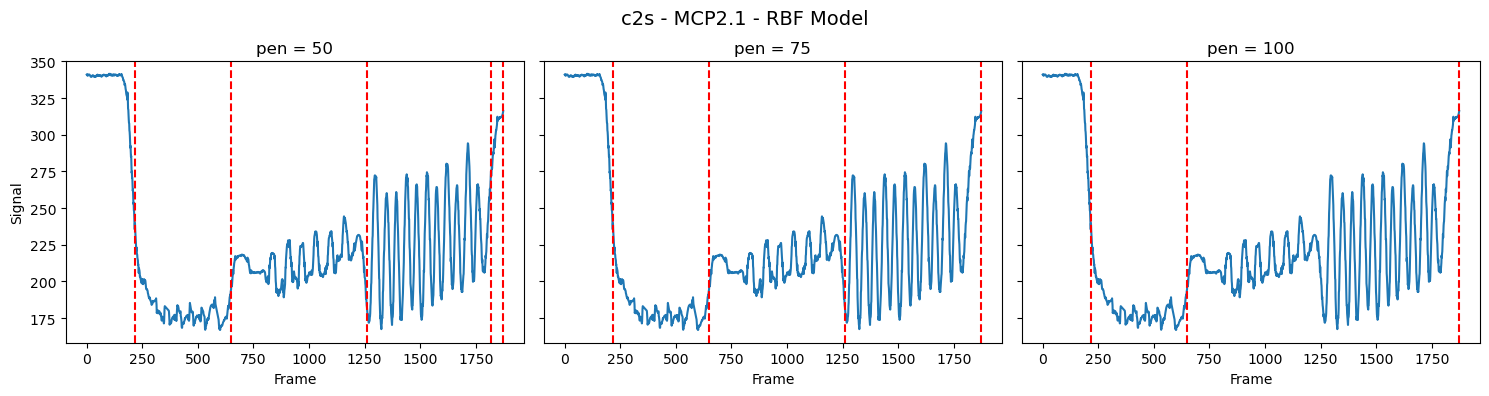

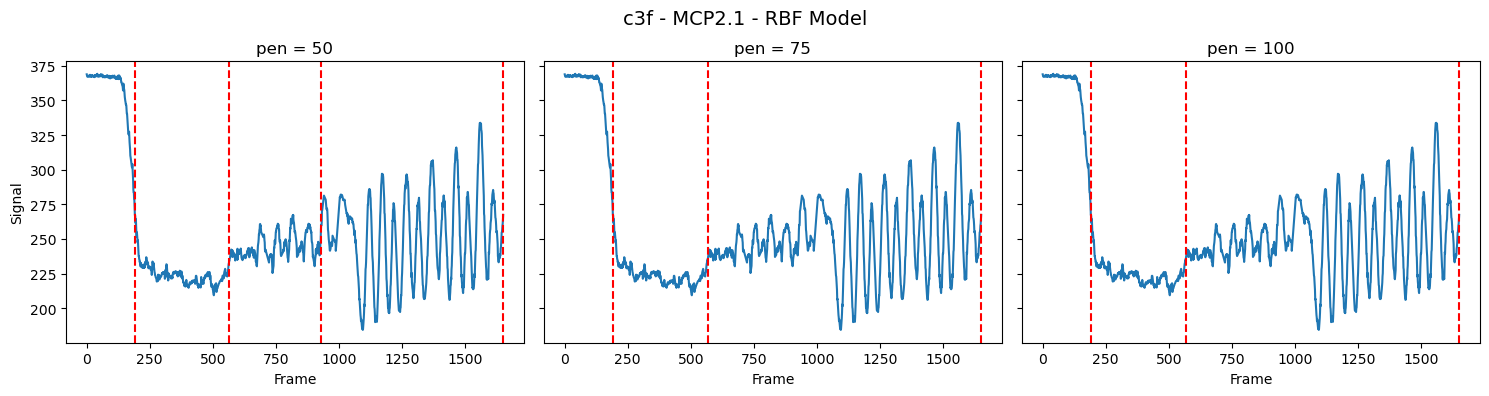

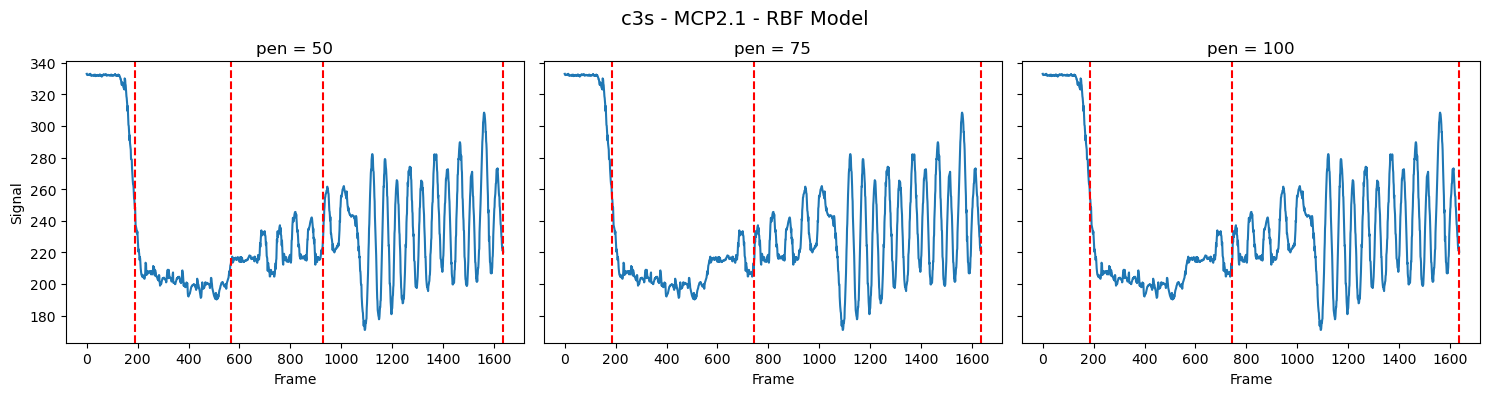

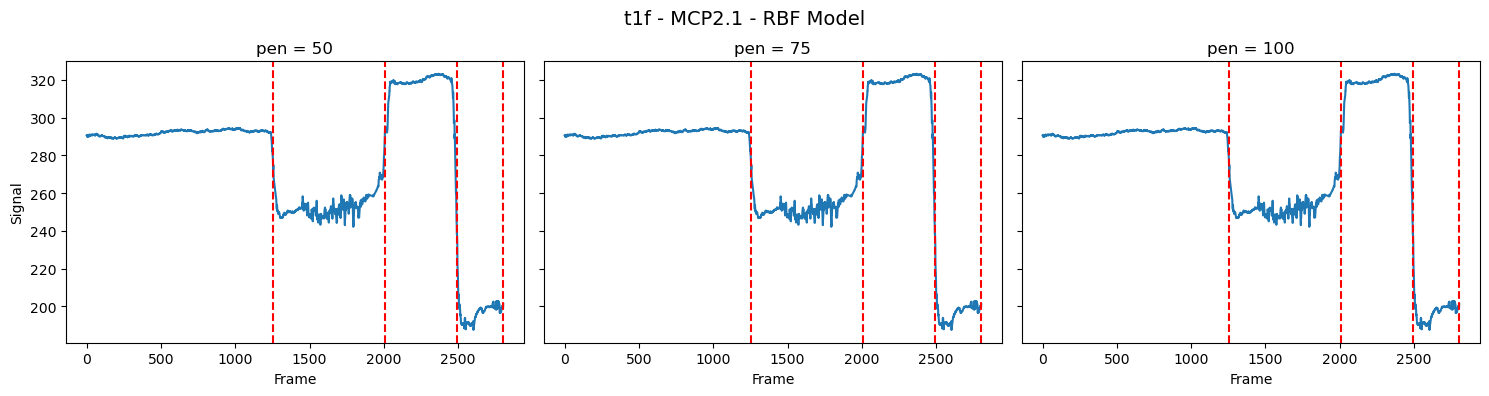

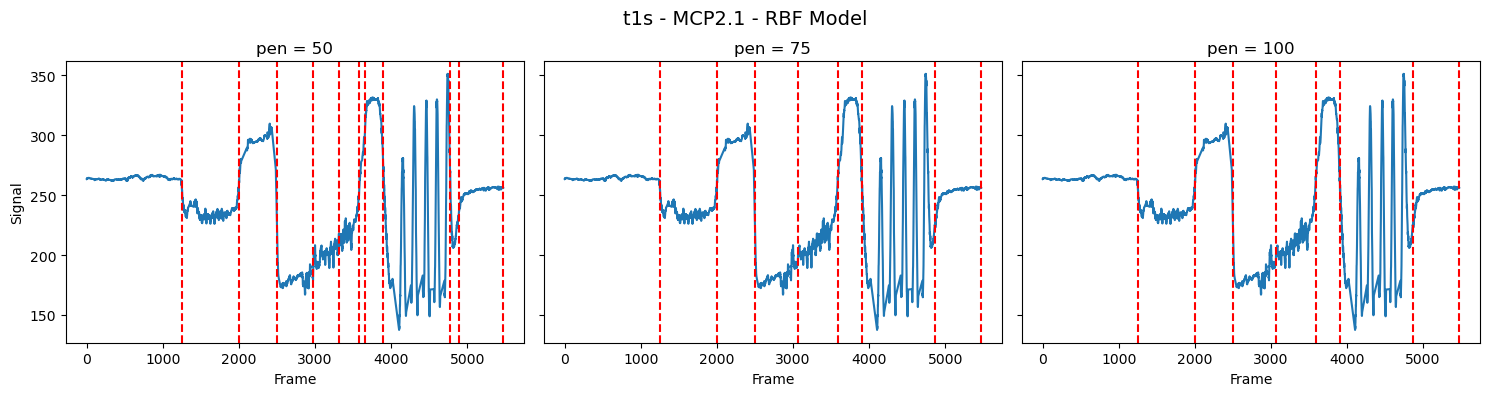

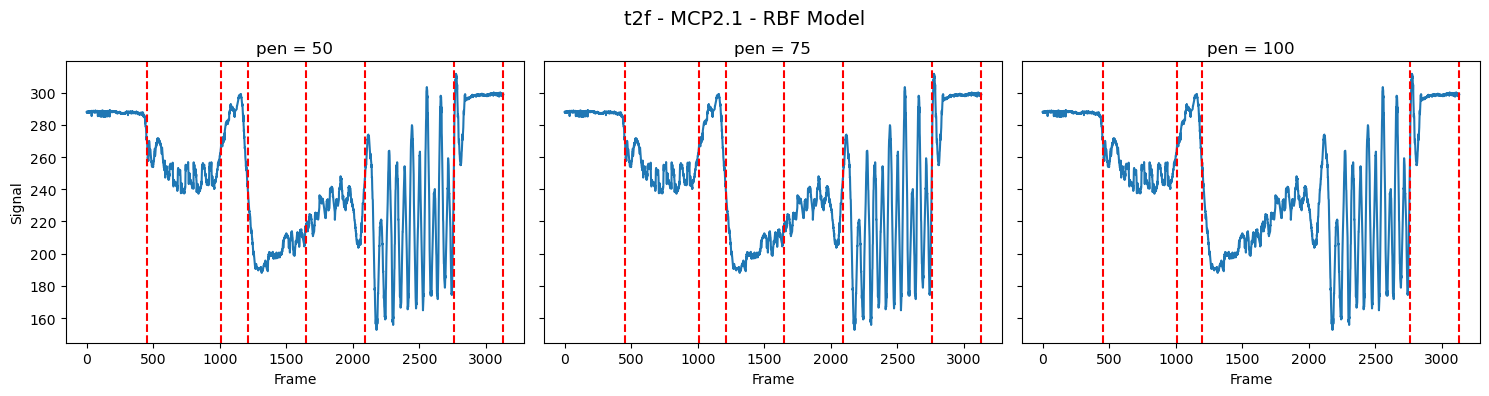

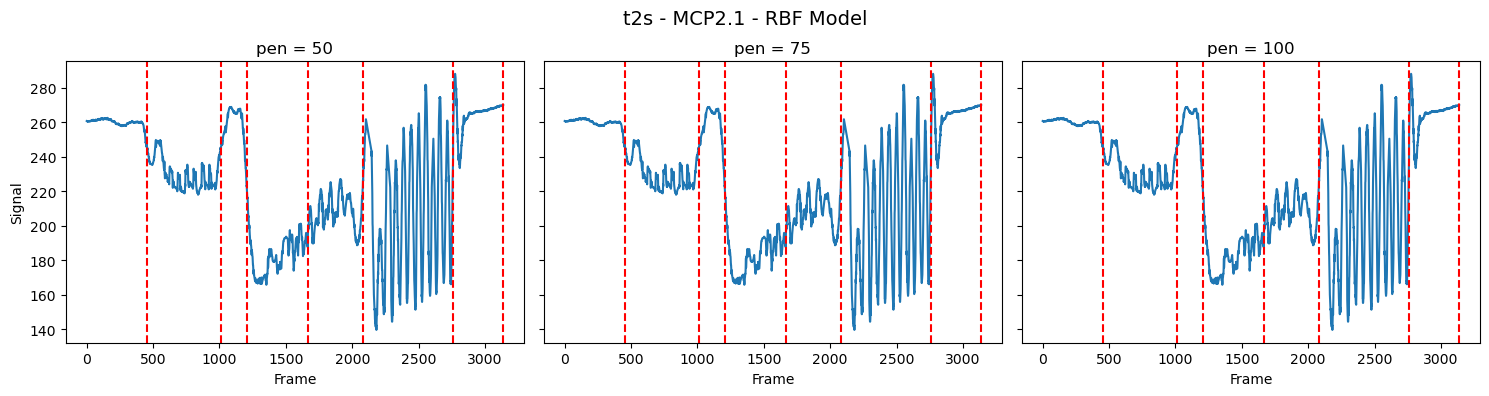

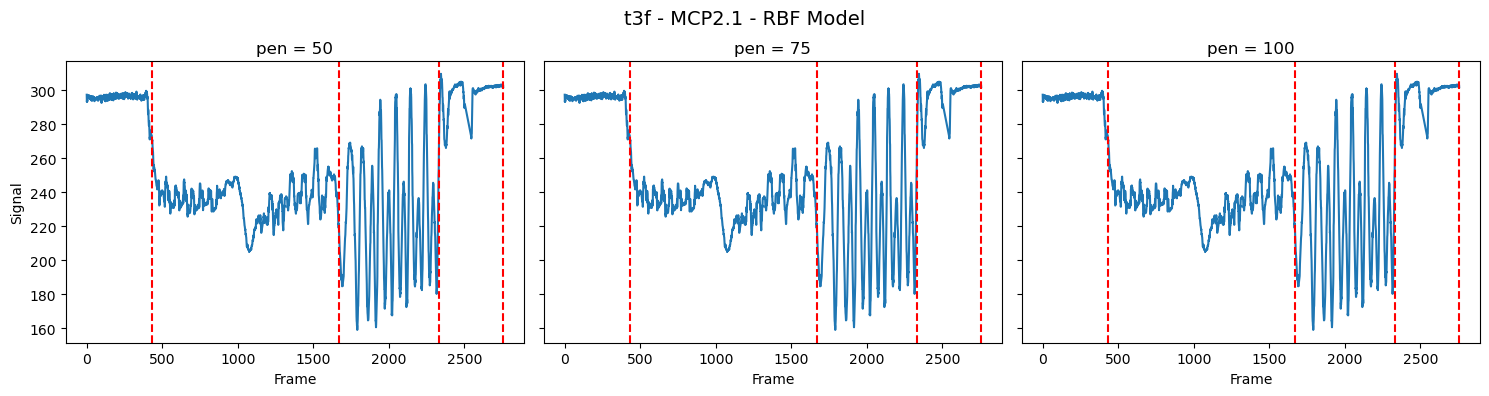

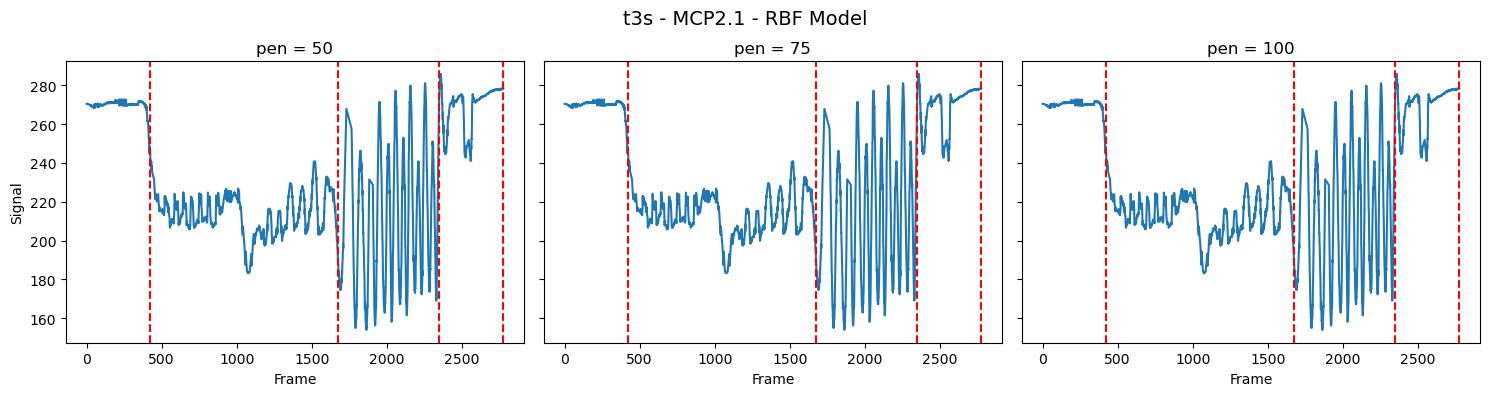

In [241]:
import matplotlib.pyplot as plt
import ruptures as rpt
import pandas as pd
import numpy as np

# Initialize an empty dictionary to hold results by base label
results_dict = {}

# Loop through each dataset
for df_name, data in dataframes.items():
    base_label = df_name[:-1]  # e.g., 'b1' from 'b1f'
    view = 'front' if df_name.endswith('f') else 'side'

    points = data['MCP2.1']
    points_np = points.to_numpy()

    penalties = [50, 75, 100]
    fig, axes = plt.subplots(1, len(penalties), figsize=(15, 4), sharey=True)
    fig.suptitle(f"{df_name} - MCP2.1 - RBF Model", fontsize=14)

    final_cps = None

    for i, pen in enumerate(penalties):
        algo = rpt.Pelt(model='rbf').fit(points_np)
        cps = algo.predict(pen=pen)
        final_cps = cps

        # Plot manually
        ax = axes[i]
        ax.plot(points_np, label="MCP2.1")
        for cp in cps:
            ax.axvline(cp, color='red', linestyle='--')
        ax.set_title(f"pen = {pen}")
        ax.set_xlabel("Frame")
        if i == 0:
            ax.set_ylabel("Signal")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

    # Save last cps (pen=100) to results
    if base_label not in results_dict:
        results_dict[base_label] = {'front': None, 'side': None}
    results_dict[base_label][view] = final_cps

# Convert dictionary to DataFrame
df_indices = pd.DataFrame.from_dict(results_dict, orient='index').reset_index()
df_indices.rename(columns={'index': 'dataset'}, inplace=True)


<Figure size 1000x300 with 0 Axes>

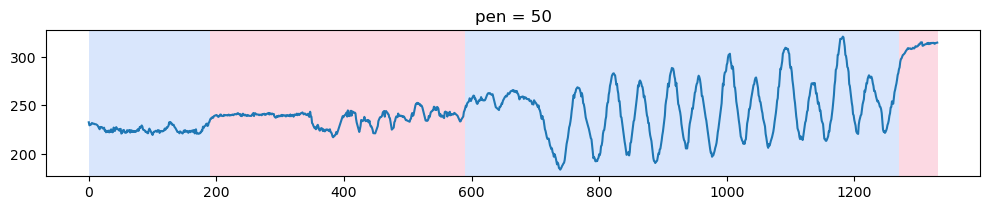

<Figure size 1000x300 with 0 Axes>

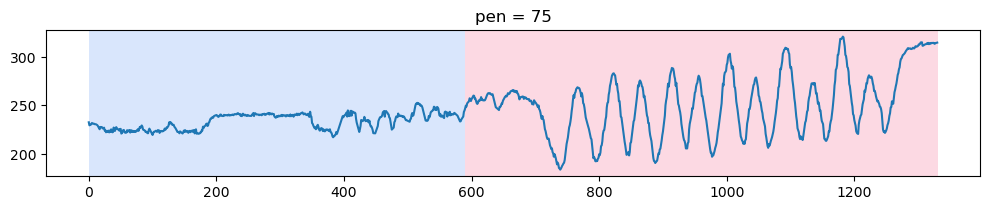

<Figure size 1000x300 with 0 Axes>

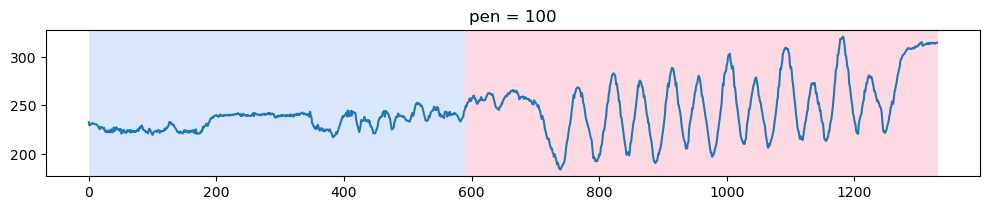

<Figure size 1000x300 with 0 Axes>

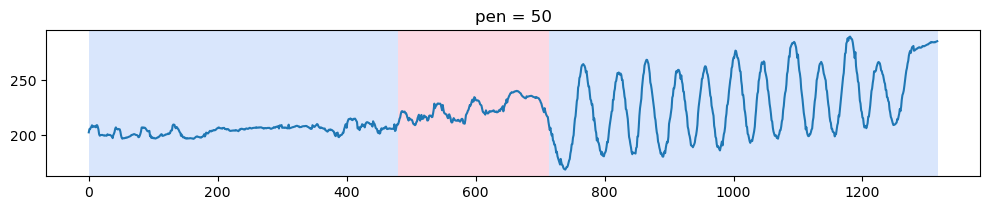

<Figure size 1000x300 with 0 Axes>

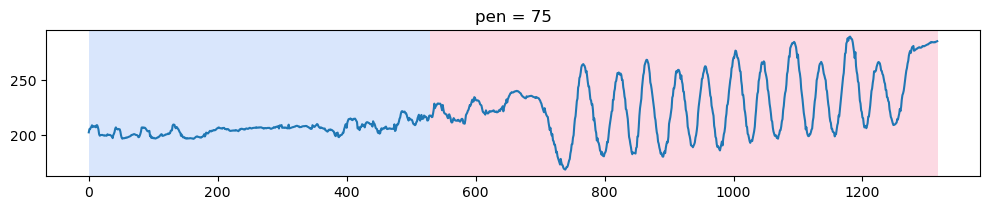

<Figure size 1000x300 with 0 Axes>

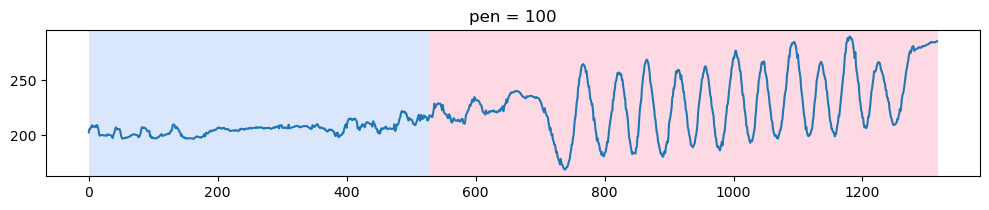

<Figure size 1000x300 with 0 Axes>

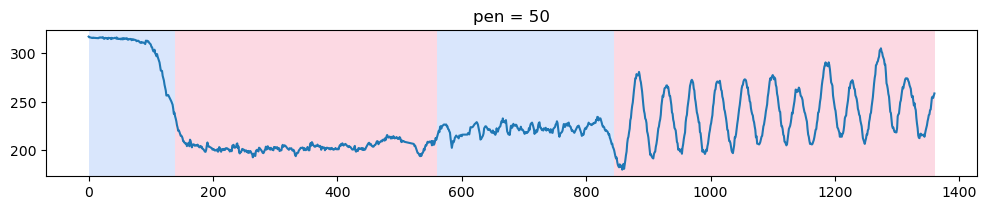

<Figure size 1000x300 with 0 Axes>

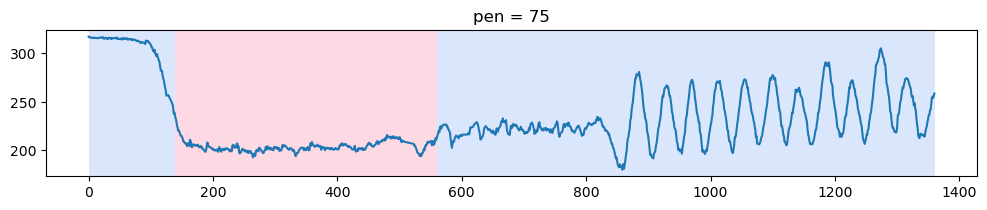

<Figure size 1000x300 with 0 Axes>

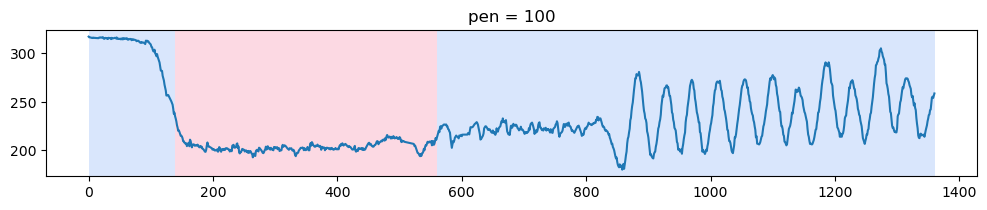

<Figure size 1000x300 with 0 Axes>

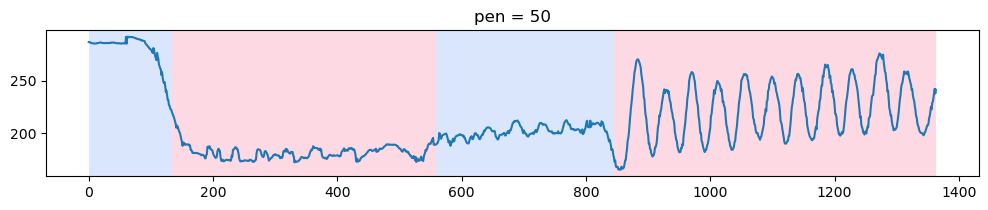

<Figure size 1000x300 with 0 Axes>

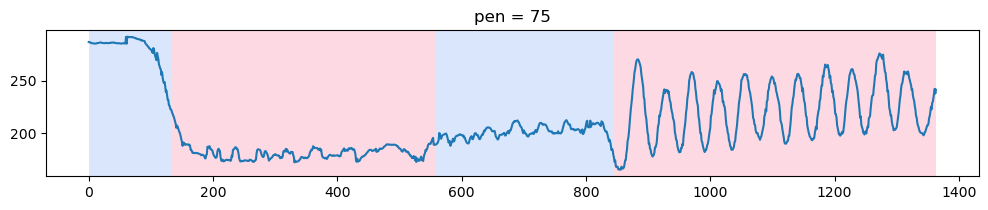

<Figure size 1000x300 with 0 Axes>

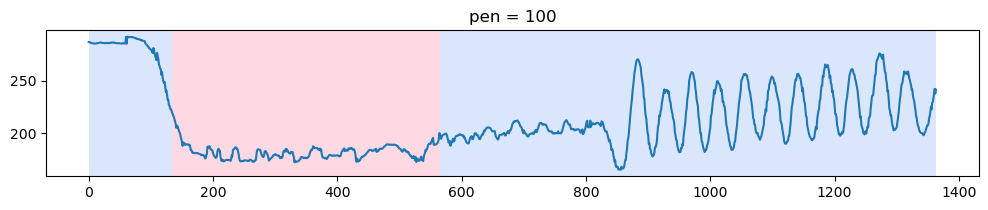

<Figure size 1000x300 with 0 Axes>

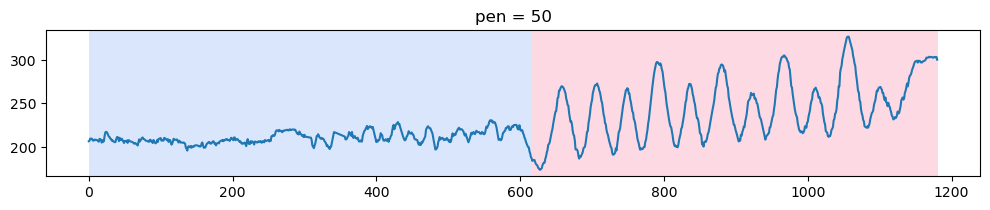

<Figure size 1000x300 with 0 Axes>

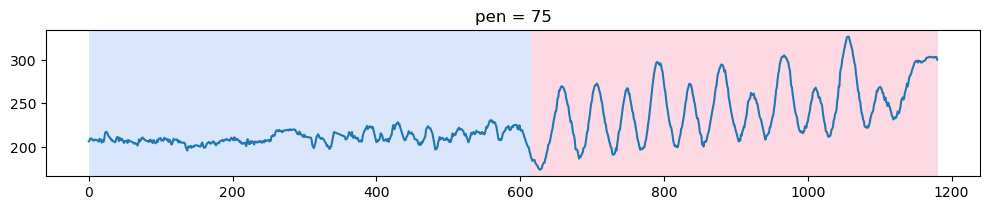

<Figure size 1000x300 with 0 Axes>

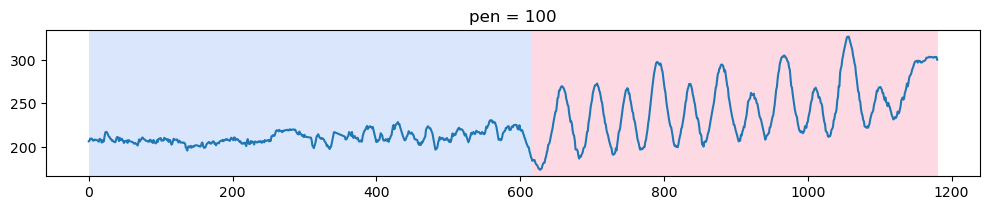

<Figure size 1000x300 with 0 Axes>

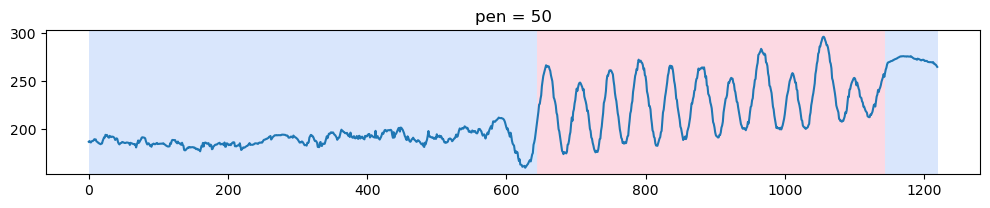

<Figure size 1000x300 with 0 Axes>

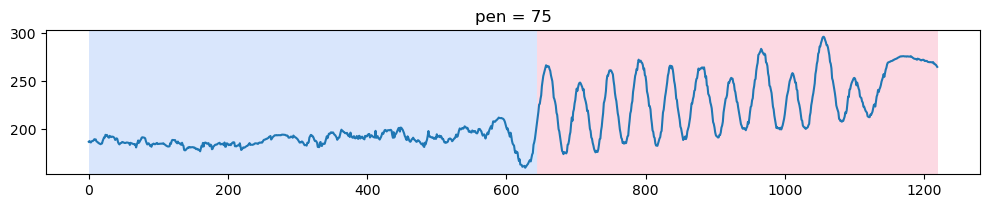

<Figure size 1000x300 with 0 Axes>

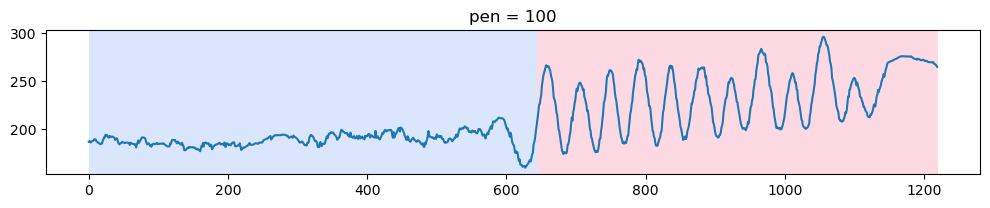

<Figure size 1000x300 with 0 Axes>

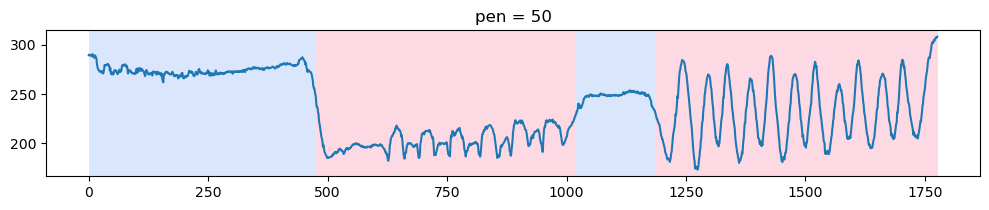

<Figure size 1000x300 with 0 Axes>

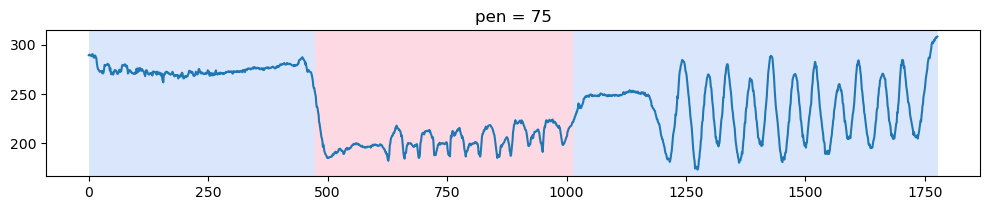

<Figure size 1000x300 with 0 Axes>

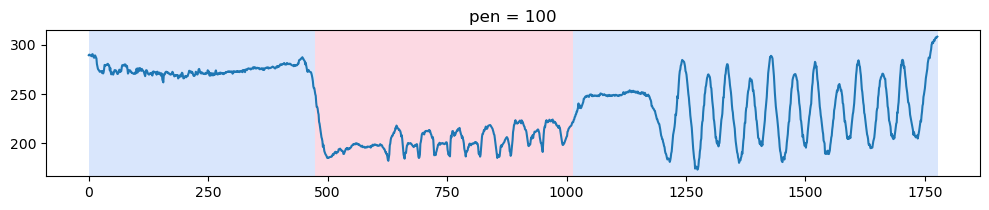

<Figure size 1000x300 with 0 Axes>

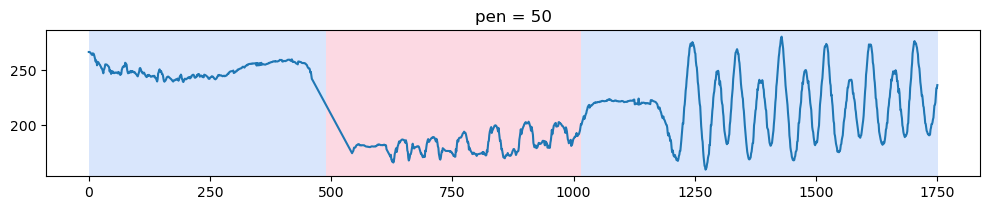

KeyboardInterrupt: 

In [239]:
# Initialize an empty dictionary to hold results by base label
results_dict = {}

for df_name, data in dataframes.items():
    # Extract base label (e.g. 'b1' from 'b1f' or 'b1s')
    base_label = df_name[:-1]  # remove last character
    view = 'front' if df_name.endswith('f') else 'side'

    points = data['MCP2.1']
    points_np = points.to_numpy()

    for pen in [50, 75, 100]:
        algo = rpt.Pelt(model='rbf').fit(points_np)
        cps = algo.predict(pen=pen)

        plt.figure(figsize=(10, 3))
        rpt.display(points_np, cps)
        plt.title(f'pen = {pen}')
        plt.show()


    # Initialize dict entry if not exists
    if base_label not in results_dict:
        results_dict[base_label] = {'front': None, 'side': None}

    # Save change points in proper column
    results_dict[base_label][view] = cps

# Convert dictionary to DataFrame
df_indices = pd.DataFrame.from_dict(results_dict, orient='index').reset_index()
df_indices.rename(columns={'index': 'dataset'}, inplace=True)


In [228]:
df_indices['front_length'] = df_indices['front'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [229]:
df_indices

dataset                           front  \
0      b1  [1730, 2510, 3215, 4015, 4258]   
1      b2   [365, 1340, 2160, 2960, 3271]   
2      b3   [345, 1270, 2050, 2845, 3053]   
3      c1   [340, 2690, 3425, 4420, 4936]   
4      c2         [535, 1325, 2195, 3219]   
5      c3         [580, 1385, 2265, 3268]   
6      t1                      [195, 622]   
7      t2                           [522]   
8      t3               [305, 2145, 3531]   

                                        side  front_length  
0                   [2010, 2830, 3535, 4556]             5  
1                          [400, 2355, 3223]             5  
2                          [350, 1970, 2947]             5  
3              [420, 1295, 1985, 2720, 3013]             5  
4              [530, 1390, 2335, 3105, 3368]             4  
5                                      [619]             4  
6                                      [498]             2  
7  [275, 1160, 1305, 2180, 2400, 3110, 3575]             1  
8                                       None             3

In [230]:
success_list = []

for _, row in df_indices.iterrows():
    # Check if number of change points in 'front' view is 4 or 5
    num_cp = len(row['front']) if isinstance(row['front'], list) else 0

    if num_cp in [1, 2, 3, 4, 5, 6, 7]:
        success_list.append(f"{row['dataset']}f")
    else:
        success_list.append(f"{row['dataset']}s")

print(success_list)


['b1f', 'b2f', 'b3f', 'c1f', 'c2f', 'c3f', 't1f', 't2f', 't3f']


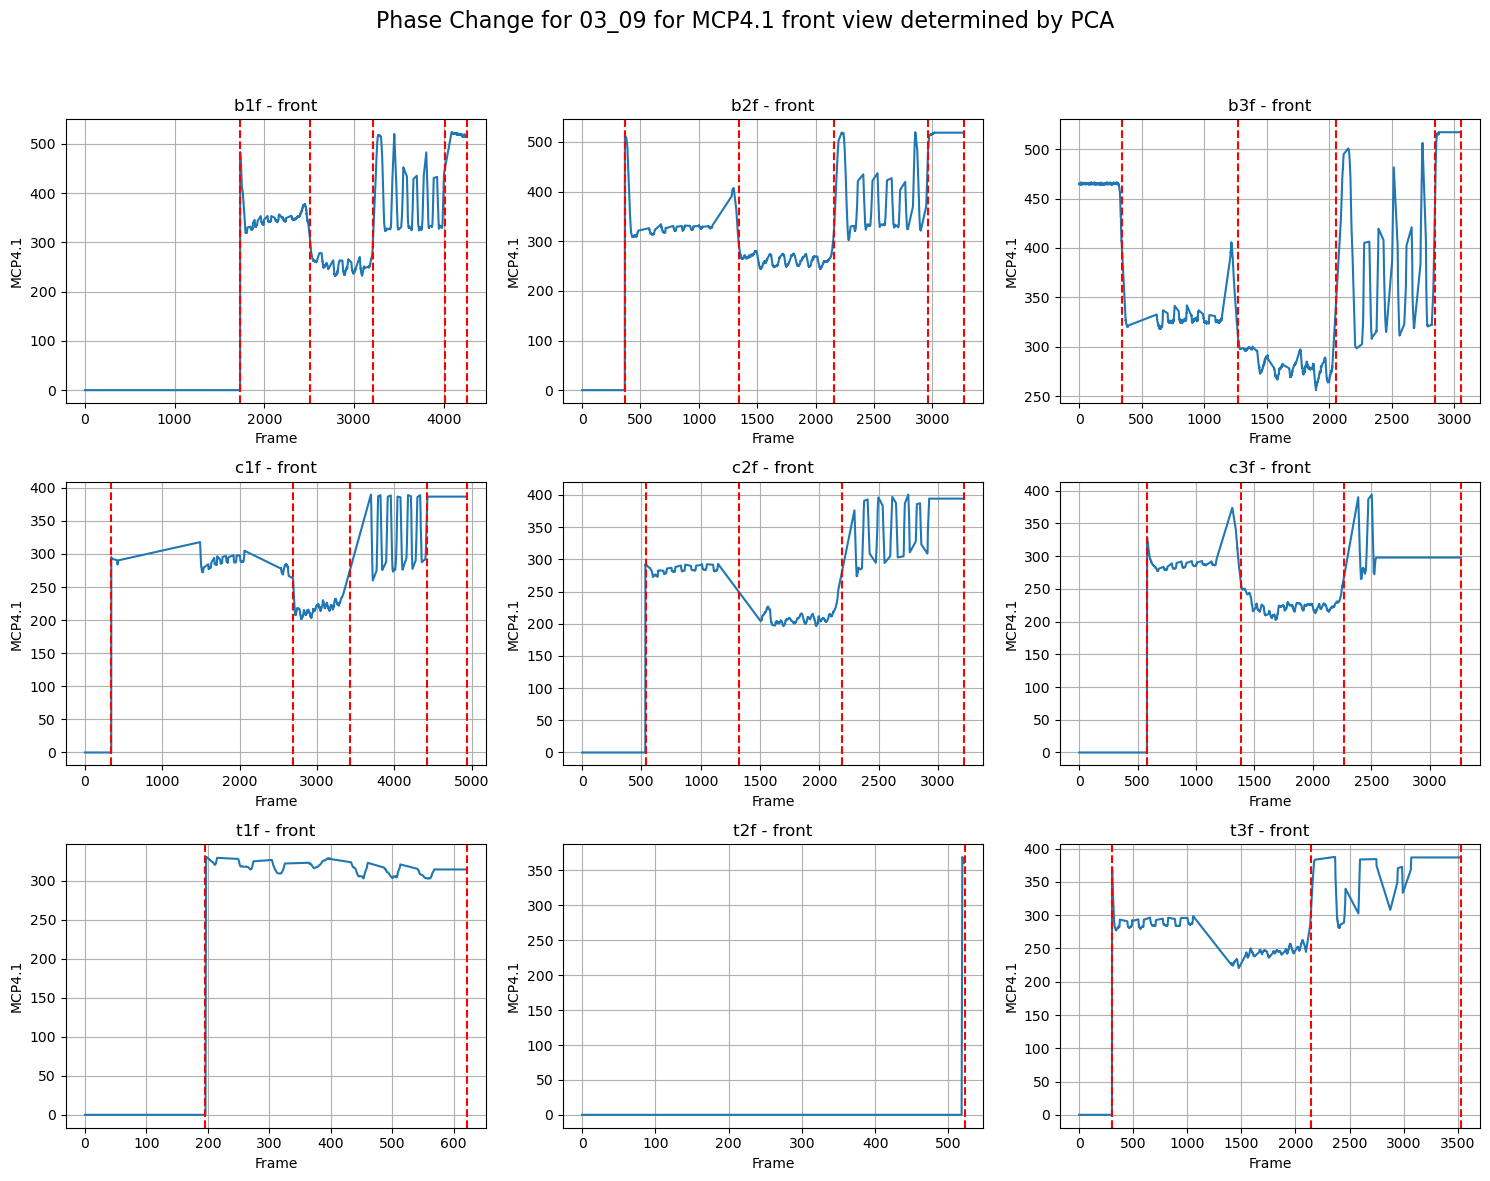

In [231]:
# Define number of plots per row
plots_per_row = 3
num_plots = len(success_list)
num_rows = int(np.ceil(num_plots / plots_per_row))

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 4 * num_rows))
axes = axes.flatten()  # Make it 1D so it's easier to index

for i, name in enumerate(success_list):
    base_name = name[:-1]
    view = 'front' if name.endswith('f') else 'side'

    # Get signal
    df = dataframes[name]
    signal = df['MCP4.1'].to_numpy()
    time = np.arange(len(signal))

    # Get change points
    row = df_indices[df_indices['dataset'] == base_name]
    change_points = row.iloc[0][view] if not row.empty else []

    # Plot in subplot
    ax = axes[i]
    ax.plot(time, signal, label='MCP4.1')
    for cp in change_points:
        ax.axvline(cp, color='red', linestyle='--')

    ax.set_title(f"{name} - {view}")
    ax.set_xlabel("Frame")
    ax.set_ylabel("MCP4.1")
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add overall title here
fig.suptitle("Phase Change for 03_09 for MCP4.1 front view determined by PCA", fontsize=16)

# Adjust layout to make room for suptitle
fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [139]:
# Create empty DataFrame to hold results
columns = ['dataset', 'movement', 'data', 'time', 'indices']
df_movements = pd.DataFrame(columns=columns)

for name in success_list:
    base_name = name[:-1]               # 'b1' from 'b1f'
    view = 'front' if name.endswith('f') else 'side'
    
    # 1. Get signal and time
    df = dataframes[name]
    x = df['MCP1.1'].to_numpy()
    t = df.index.to_numpy() if 'time' not in df else df['time'].to_numpy()

    # 2. Get change points
    row = df_indices[df_indices['dataset'] == base_name]
    if row.empty:
        continue  # skip if no match

    change_points = row.iloc[0][view]
    if len(change_points) < 3:
        continue  # not enough points to split into 3 parts

    # 3. Define movement segments
    segment_info = {
        'hand_OC': (change_points[0], change_points[1]),
        'hand_PS': (change_points[1], change_points[2]),
        'arm_EF': (change_points[2], len(x))  # to end
    }

    for movement, (start, end) in segment_info.items():
        if end - start < 400:
            continue  # skip short segments

        segment_data = x[start:end]
        segment_time = t[start:end]

        df_movements = pd.concat([
            df_movements,
            pd.DataFrame([{
                'dataset': base_name,
                'movement': movement,
                'data': segment_data,
                'time': segment_time,
                'indices': (start, end)
            }])
        ], ignore_index=True)

# preview result
df_movements.head()
df_movements.tail()


dataset movement                                               data  \
16      c3  hand_PS  [309.50228428571427, 308.48220842105263, 307.4...   
17      c3   arm_EF  [336.15594, 341.42813, 343.06091, 345.35739, 3...   
18      t3  hand_OC  [398.48032, 393.82822, 391.99323, 391.08386, 3...   
19      t3  hand_PS  [278.54636, 275.8075, 273.53549, 270.30017, 26...   
20      t3   arm_EF  [301.40118, 305.00659, 308.67151, 311.48022, 3...   

                                                 time       indices  
16  [1416, 1417, 1418, 1419, 1420, 1421, 1422, 142...  (1415, 2325)  
17  [2326, 2327, 2328, 2329, 2330, 2331, 2332, 233...  (2325, 3368)  
18  [296, 297, 298, 299, 300, 301, 302, 303, 304, ...   (295, 1320)  
19  [1321, 1322, 1323, 1324, 1325, 1326, 1327, 132...  (1320, 2140)  
20  [2141, 2142, 2143, 2144, 2145, 2146, 2147, 214...  (2140, 3531)

In [161]:
# Apply and create new columns
df_movements[['peaks', 'troughs', 'euclidean_dis']] = df_movements.apply(compute_peaks_troughs, axis=1)
df_movements

Error processing row 13: 'NoneType' object is not subscriptable
Error processing row 14: 'NoneType' object is not subscriptable


dataset movement                                               data  \
0       b1  hand_OC  [0.0, 448.0502, 445.30121, 443.25018, 442.3430...   
1       b1  hand_PS  [317.83844, 312.74094, 311.93942, 311.05396, 3...   
2       b1   arm_EF  [343.40897, 345.45416, 349.21518, 351.87399, 3...   
3       b2  hand_OC  [439.14294, 439.14536, 432.31442, 423.14078, 4...   
4       b2  hand_PS  [311.82791, 312.01193, 310.13269, 306.78973, 3...   
5       b2   arm_EF  [335.06079, 339.45883, 342.71967, 346.3273, 34...   
6       b3  hand_OC  [452.02008, 448.15372, 445.60977, 438.82437, 4...   
7       b3  hand_PS  [325.61445755458516, 325.1283611790393, 324.64...   
8       b3   arm_EF  [350.39087590909094, 353.8283927272727, 357.26...   
9       c1  hand_OC  [0.0, 0.0, 442.80359, 441.81766, 440.32602, 43...   
10      c1  hand_PS  [298.9317, 297.18646, 296.37354, 295.71088, 29...   
11      c1   arm_EF  [330.20517, 332.38062, 337.83807, 337.98004, 3...   
12      c2  hand_OC  [349.91284, 349.6095, 348.84729, 347.63525, 34...   
13      c2  hand_PS  [262.88562, 261.86145, 260.20886, 259.50739, 2...   
14      c2   arm_EF  [291.27039, 293.63306, 296.07333, 297.79172, 3...   
15      c3  hand_OC  [419.08252, 416.78674, 411.8371, 409.60016, 40...   
16      c3  hand_PS  [309.50228428571427, 308.48220842105263, 307.4...   
17      c3   arm_EF  [336.15594, 341.42813, 343.06091, 345.35739, 3...   
18      t3  hand_OC  [398.48032, 393.82822, 391.99323, 391.08386, 3...   
19      t3  hand_PS  [278.54636, 275.8075, 273.53549, 270.30017, 26...   
20      t3   arm_EF  [301.40118, 305.00659, 308.67151, 311.48022, 3...   

                                                 time       indices  \
0   [1746, 1747, 1748, 1749, 1750, 1751, 1752, 175...  (1745, 2515)   
1   [2516, 2517, 2518, 2519, 2520, 2521, 2522, 252...  (2515, 3215)   
2   [3216, 3217, 3218, 3219, 3220, 3221, 3222, 322...  (3215, 4258)   
3   [401, 402, 403, 404, 405, 406, 407, 408, 409, ...   (400, 1345)   
4   [1346, 1347, 1348, 1349, 1350, 1351, 1352, 135...  (1345, 2155)   
5   [2156, 2157, 2158, 2159, 2160, 2161, 2162, 216...  (2155, 3271)   
6   [336, 337, 338, 339, 340, 341, 342, 343, 344, ...   (335, 1330)   
7   [1331, 1332, 1333, 1334, 1335, 1336, 1337, 133...  (1330, 2070)   
8   [2071, 2072, 2073, 2074, 2075, 2076, 2077, 207...  (2070, 3053)   
9   [431, 432, 433, 434, 435, 436, 437, 438, 439, ...   (430, 1300)   
10  [1301, 1302, 1303, 1304, 1305, 1306, 1307, 130...  (1300, 1980)   
11  [1981, 1982, 1983, 1984, 1985, 1986, 1987, 198...  (1980, 3013)   
12  [496, 497, 498, 499, 500, 501, 502, 503, 504, ...   (495, 1375)   
13  [1376, 1377, 1378, 1379, 1380, 1381, 1382, 138...  (1375, 2170)   
14  [2171, 2172, 2173, 2174, 2175, 2176, 2177, 217...  (2170, 3219)   
15  [571, 572, 573, 574, 575, 576, 577, 578, 579, ...   (570, 1415)   
16  [1416, 1417, 1418, 1419, 1420, 1421, 1422, 142...  (1415, 2325)   
17  [2326, 2327, 2328, 2329, 2330, 2331, 2332, 233...  (2325, 3368)   
18  [296, 297, 298, 299, 300, 301, 302, 303, 304, ...   (295, 1320)   
19  [1321, 1322, 1323, 1324, 1325, 1326, 1327, 132...  (1320, 2140)   
20  [2141, 2142, 2143, 2144, 2145, 2146, 2147, 214...  (2140, 3531)   

                                                peaks  \
0          [1973, 2085, 2142, 2195, 2281, 2370, 2469]   
1                [2639, 2769, 2869, 2966, 3063, 3154]   
2                [3303, 3441, 3565, 3679, 3791, 3904]   
3          [512, 666, 765, 835, 894, 982, 1057, 1293]   
4                [1453, 1622, 1726, 1813, 1916, 2011]   
5          [2247, 2384, 2506, 2629, 2742, 2853, 2915]   
6    [433, 540, 687, 772, 880, 965, 1045, 1177, 1291]   
7          [1485, 1543, 1657, 1765, 1870, 1961, 2040]   
8   [2164, 2297, 2356, 2411, 2472, 2524, 2577, 263...   
9         [669, 730, 801, 890, 985, 1076, 1173, 1261]   
10                                 [1572, 1712, 1848]   
11  [2182, 2238, 2504, 2600, 2690, 2743, 2818, 288...   
12        [673, 738, 805, 891, 983, 1085, 1160, 1283]   
13           

## Viewing peaks and troughs

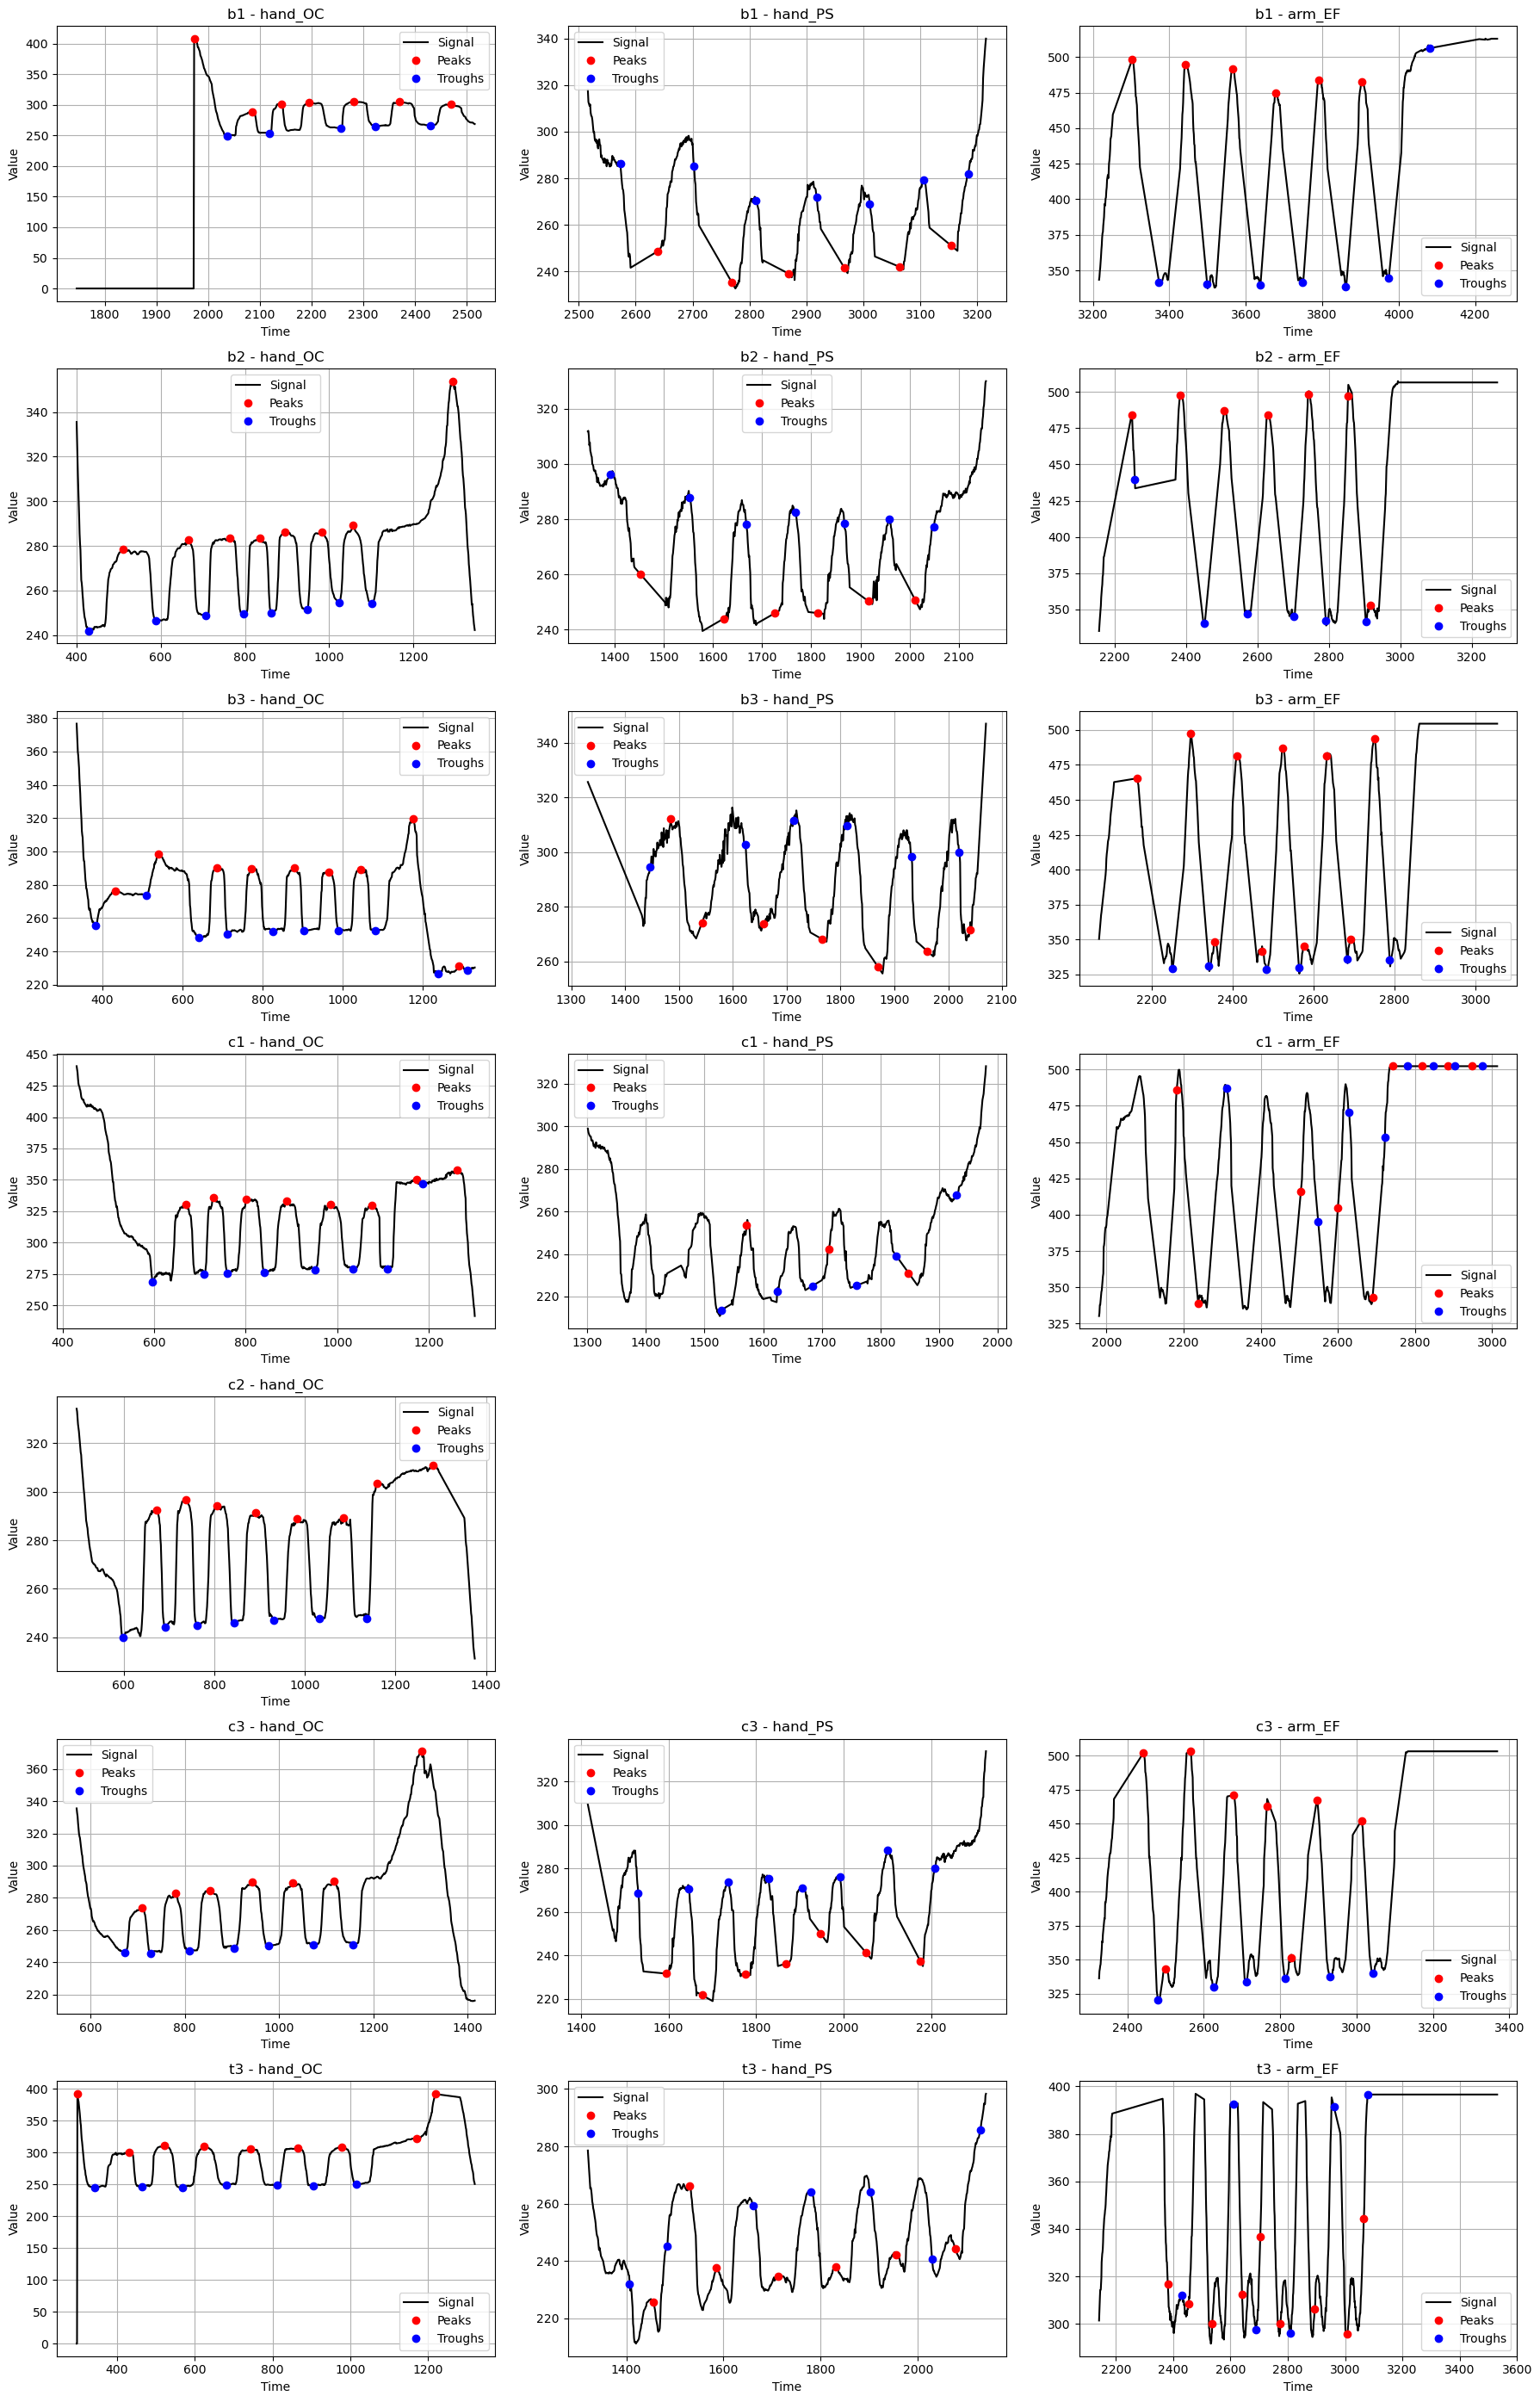

In [162]:
# Filter rows where 'peaks' is not None
# valid_rows = df_movements[df_movements['peaks'].notna()].reset_index()

num_plots = len(df_movements)
cols = 3
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axes = axes.flatten()


for i, (idx, row) in enumerate(df_movements.iterrows()):
    ax = axes[i]

    if row['peaks'] is None:
        fig.delaxes(ax)
        continue


    if row['movement'] == 'hand_OC':
        data = row['euclidean_dis']
    else:
        data = row['data']
    
    # Plot time vs data
    ax.plot(row['time'], data, label='Signal', color='black')

    # Plot peaks (if any)
    if isinstance(row['peaks'], (np.ndarray, list)):
        ax.plot(row['peaks'], np.interp(row['peaks'], row['time'], data), 'ro', label='Peaks')

    # Plot troughs (if any)
    if isinstance(row['troughs'], (np.ndarray, list)):
        ax.plot(row['troughs'], np.interp(row['troughs'], row['time'], data), 'bo', label='Troughs')

    # Add titles and labels
    ax.set_title(f"{row['dataset']} - {row['movement']}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
